# section three

## imperfect financial market ($\phi=0.5$)

## setup

In [184]:
# parameters setting
# tech
alpha=0.3
theta=0.49
fc_m=4.68
fc_s=0

# depreciation
delta=0.06

# describing the process for entrepreneurial talent
gamma=0.89
eta=4.84

# discount factor
beta=0.92

# relative risk aversion
sigma=1.5

# intratemporal elasticity of substitution
epsilon=1

# service share in consumption
psi=0.91

# imperfect financial market
phi=0.8

In [185]:
# import packages
import timeit
import numpy as np
from numba import njit,prange
import numba
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [186]:
# talent probability
from scipy.stats import pareto
def discrete_pareto(shape,lower_bound,upper_bound,grid_numder):
    ability=np.linspace(pareto.ppf(lower_bound,shape),pareto.ppf(upper_bound,shape),(grid_numder+1))
    probability=np.diff(pareto.cdf(ability,shape)) / (upper_bound-lower_bound)
    zgrid = ability[1:]
    return zgrid,probability

In [187]:
# add kgrid to 250

kmin =0
kmax =250
n_k = 250
kgrid = np.linspace(kmin, kmax, n_k)
zgrid,p_z = discrete_pareto(4.84,0.6,0.9995,40)
n_z = len(zgrid)
V0 = np.zeros((n_k, n_z))
P=np.zeros((n_z, n_z))
for i in range(n_z):
    for j in range(n_z):
        if j==i:
            P[i,j]=gamma+(1-gamma)*p_z[j]
        else:
            P[i,j]=(1-gamma)*p_z[j]

In [188]:
def u(c):
    if c > 0:
        res = (c**(1-sigma))/(1-sigma)
    else:
        res = -np.inf
    return res
if compile:
    u=njit(u)

def budget_worker(a, x, w, r):
    return w + (1+r)*a - x
if compile:
    budget_worker=njit(budget_worker)

@njit
def f(z_index, k, l):
    return zgrid[z_index]*(k**alpha)*(l**theta)

@njit
def capital_constraint(k, z_index, a_index , w, r):
    R=r+delta
    f=phi*(1/theta-1)*w*(theta*zgrid[z_index]*k**alpha/w)**(1/(1-theta))+(1+r)*kgrid[a_index]-R*k-(1+r)*fc_m-(1-phi)*(1-delta)*k
    return f


@njit
def budget_entrepreneur(z_index, k, l, a , x , w, r): # add fixed cost fc_m
    R = r + delta
    return f(z_index, k, l) + (1+r)*a - R*k - w*l - x - (1+r)*fc_m


In [189]:
@njit
def capital_constraint_plot(k_index):
    k=np.zeros((100,n_z))
    x=np.zeros(100)
    for i in range(100):
        x[i]=i
        for j in range(n_z):
            k[i,j]=capital_constraint(i, j , k_index , 0.7,0.05)
    return x,k

In [190]:
@njit
def capital_constraint_plot_z(z_index):
    k=np.zeros((100,200))
    x=np.zeros(100)
    for i in range(100):
        x[i]=i
        for j in range(200):
            k[i,j]=capital_constraint(i, z_index , j , 0.35,0.074)
    return x,k

In [191]:
# x,k=capital_constraint_plot_z(3)
# for i in range(200):
#     plt.plot(x,k[:,i],label=kgrid[i])
# plt.axhline(0)
# # plt.legend()

In [192]:
# x,k=capital_constraint_plot(0)
# for i in range(n_z):
#     plt.plot(x,k[:,i],label=zgrid[i])
# plt.axhline(0)
# # plt.legend()

In [193]:
# x,k=capital_constraint_plot(45)
# for i in range(n_z):
#     plt.plot(x,k[:,i],label=zgrid[i])
# plt.axhline(0)
# # plt.legend()

In [194]:
# x,k=capital_constraint_plot(199)
# for i in range(n_z):
#     plt.plot(x,k[:,i],label=zgrid[i])
# plt.axhline(0)
# # plt.legend()

In [195]:
def V_current_worker(k_next_index, k_index, z_index, V_next, w, r):
    c = budget_worker(kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index,:]*V_next[k_next_index,:]) # expectation
    res = u(c) + beta*(gamma*V_next[k_next_index,z_index]+(1-gamma)*EV)
    return res
if compile:
    V_current_worker = njit(V_current_worker)

def V_max_worker(k_index, z_index, k_start, V, w, r):
    V_max = -np.inf
    for j in range(k_start,n_k):
        k_next = kgrid[j]
        V_new=V_current_worker(j,k_index,z_index, V, w, r)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:break
    return V_max, g_k, k_start
if compile:
    V_max_worker = njit(V_max_worker)

def V_update_worker(V, w, r):
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    for i_z in prange(n_z): 
        k_start = 0
        for i_k in range(k_start,n_k): # loop over all state k
            V_new[i_k, i_z], g_new[i_k, i_z] ,k_start= V_max_worker(i_k, i_z,k_start,V,w,r)
    return V_new, g_new
if compile:
    V_update_worker = njit(V_update_worker, parallel=True)

In [196]:
# # thanks to ChatGPT ！！！！！！！！

# # 保持 capital_bound_matrix 作为一个纯Python函数  我们只需要加速主线就好了！！！
# # 将计算结果作为参数传递：在需要Numba加速的函数中，避免直接调用不可加速的函数，将计算结果（如 bound_matrix 和 opt_matrix）作为参数传递。(从主线剥离)
# def capital_bound_matrix(w, r):
#     bound_matrix = np.zeros((n_k, n_z))
#     for i_k in range(n_k):
#         for i_z in range(n_z):
#             z_index = i_z
#             a_index = i_k
#             solution = root(capital_constraint, x0=10, args=(z_index, a_index, w, r))
#             if solution.success:
#                 bound_matrix[i_k, i_z] = np.max(solution.x)
#             else:
#                 bound_matrix[i_k, i_z] = 0
#             # print(solution.x)
#     return bound_matrix



1. 用全局最优找极值点，判断那个点它的constraint数值正负
2. 如果负就跳过，为0
3. 如果正，就再去搜索零点，以极值点为lower bound

In [197]:
def capital_bound_matrix(w, r):
    bound_matrix = np.zeros((n_k, n_z))
    for i_k in range(n_k):
        for i_z in range(n_z):
            z_index = i_z
            a_index = i_k
            k_max = (((r+delta)+(1-delta)*(1-phi))/((phi*w*(theta*zgrid[z_index]/w)**(1/(1-theta)))*alpha/theta))**(1/((alpha/(1-theta))-1))
            res = capital_constraint(k_max, z_index, a_index , w, r)
            if res < 0 :
                bound_matrix[i_k,i_z]=0
            if res == 0 :
                bound_matrix[i_k,i_z]=k_max
            if res > 0 :
                solution = brentq(capital_constraint, k_max,1e+10, args=(z_index, a_index, w, r))
                bound_matrix[i_k,i_z] = solution
            # print(k_max,res)
    return  bound_matrix
    

In [198]:
capital_bound_matrix(0.35,0.074)

array([[   0.        ,    0.        ,    0.        , ..., 5709.72712172,
        6261.77640032, 6854.8914024 ],
       [   0.        ,    0.        ,    0.        , ..., 5717.88835507,
        6269.93512025, 6863.04787412],
       [   0.        ,    0.        ,    0.        , ..., 5726.04270627,
        6278.08757026, 6871.19862291],
       ...,
       [ 979.41814736, 1006.03938462, 1035.26873839, ..., 7570.0293479 ,
        8132.18923678, 8734.71683446],
       [ 983.14212217, 1009.81750953, 1039.10480545, ..., 7577.08053404,
        8139.30582485, 8741.89527331],
       [ 986.86544693, 1013.59488903, 1042.94002494, ..., 7584.12873544,
        8146.41953247, 8749.07093853]])

In [199]:
@njit
def capital_opt_unconditional(k_index, z_index, w, r):
    R = r + delta
    opt = ((R / alpha / zgrid[z_index]) * (w * alpha / (R * theta)) ** theta) ** (1 / (alpha + theta - 1))
    return opt

@njit
def capital_demand(k_index, z_index, w, r, bound_matrix): # KKT
    if bound_matrix[k_index, z_index] > capital_opt_unconditional(k_index, z_index, w, r):
        k_demand = capital_opt_unconditional(k_index, z_index, w, r)
    else:
        k_demand = bound_matrix[k_index, z_index]
    return k_demand

@njit
def capital_opt_matrix(w, r):
    R = r + delta
    capital_matrix = np.zeros((n_k, n_z))
    for i_k in range(n_k):
        for i_z in range(n_z):
            capital_matrix[i_k, i_z] = capital_opt_unconditional(i_k, i_z, w, r)
    return capital_matrix


@njit
def V_current_entrepreneur(k_next_index, k_index, z_index, V_next, w, r, bound_matrix):
    R = r + delta
    k = capital_demand(k_index, z_index, w, r, bound_matrix)
    l = (theta*zgrid[z_index]*(k**alpha)/w)**(1/(1-theta))
    c = budget_entrepreneur(z_index, k, l, kgrid[k_index], kgrid[k_next_index], w, r)
    EV = np.sum(P[z_index, :] * V_next[k_next_index, :])  # expectation
    if k==0: # 此时没有动机创业，默认为0效用
        res = 0
    res = u(c) + beta * (gamma * V_next[k_next_index, z_index] + (1 - gamma) * EV)

    return res

@njit
def V_max_entrepreneur(k_index, z_index, k_start, V, w, r, bound_matrix):
    V_max = -np.inf
    for j in range(k_start, n_k):
        k_next = kgrid[j]
        V_new = V_current_entrepreneur(j, k_index, z_index, V, w, r, bound_matrix)
        if V_new > V_max:
            V_max = V_new
            g_k = k_next
            k_start = j
        else:
            break
    return V_max, g_k, k_start

In [200]:
def V_update(V, w, r,bound_matrix):
    V_new = np.zeros((n_k, n_z))
    g_new = np.zeros((n_k, n_z))
    state_new = np.zeros((n_k, n_z))
    # V_worker,g_worker=V_update_worker(V, w, r)
    # V_entrepreneur,g_entrepreneur=V_update_entrepreneur(V, w, r,bound_matrix)
    for i_z in prange(n_z):
        k_start_worker=0
        k_start_entrepreneur=0
        for i_k in range(n_k):
            V_new_worker, g_new_worker,k_start_worker= V_max_worker(i_k, i_z,k_start_worker,V,w,r)
            V_new_entrepreneur, g_new_entrepreneur,k_start_entrepreneur= V_max_entrepreneur(i_k, i_z,k_start_entrepreneur,V,w,r,bound_matrix)
            if V_new_worker>=V_new_entrepreneur:
                V_new[i_k, i_z]=V_new_worker
                g_new[i_k, i_z]=g_new_worker
            if V_new_entrepreneur>V_new_worker:
                V_new[i_k, i_z]=V_new_entrepreneur
                g_new[i_k, i_z]=g_new_entrepreneur
                state_new[i_k, i_z]=1
    return V_new, g_new, state_new
if compile:
    V_update = njit(V_update, parallel=True)

def V_iteration(V_initial,tol,w,r,bound_matrix):
    V = V_initial
    error = np.inf
    count = 0
    max_iter = 1000
    # print_skip = 50
    while count < max_iter and error > tol:
        V_new, g_new, state_new = V_update(V, w, r,bound_matrix)
        error = np.max(np.abs(V_new - V))
        V = V_new
        count = count + 1
        # if count % print_skip == 0:
            # print(f"Error at iteration {count} is {error}.")
    # if error > tol:
    #     print("Failed to converge!")
    # else:
    #      print(f"\nConverged in {count} iterations.")
    return V_new, g_new, state_new

## iterate together

In [201]:
start_time = timeit.default_timer()
V, g , state_entrepreneur= V_iteration(V0,tol=1e-7,w=0.7,r=0.074,bound_matrix=capital_bound_matrix(0.7,0.074))
print("The time difference is :", timeit.default_timer() - start_time)

The time difference is : 4.925073100021109


In [202]:
state_entrepreneur

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [203]:
np.sum(state_entrepreneur)

8222.0

Text(0, 0.5, '$k_{t+1}$')

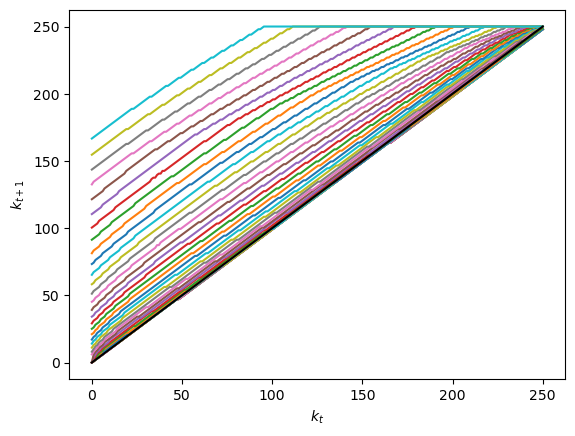

In [204]:
for i in range(n_z):
    plt.plot(kgrid,g[:,i],label='z='+ str(zgrid[i]))
plt.plot(kgrid,kgrid,label="45 degree",color='black')
plt.xlabel("$k_t$")
plt.ylabel("$k_{t+1}$")
# plt.title('policy function,$w=0.35,r=0.074$')
# plt.legend()

Text(0, 0.5, '$V$')

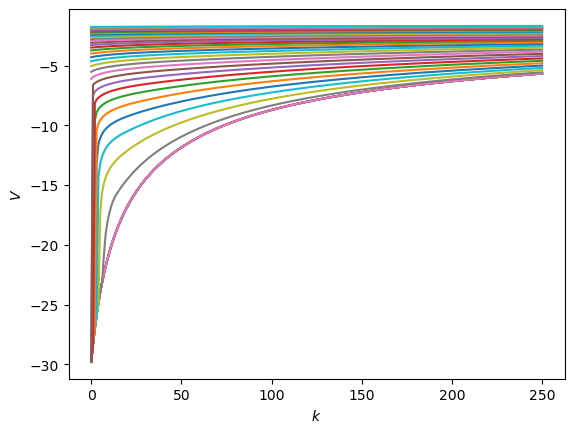

In [205]:
for i in range (n_z):
    plt.plot(kgrid,V[:,i],label='z='+ str(zgrid[i]))
plt.xlabel("$k$")
plt.ylabel("$V$")
# plt.title('value function,$w=0.35,r=0.074$')
# plt.legend()

In [206]:
V

array([[-29.8055219 , -29.8055219 , -29.8055219 , ...,  -1.85712929,
         -1.80278964,  -1.75250905],
       [-28.31314788, -28.31314788, -28.31314788, ...,  -1.85610556,
         -1.80192706,  -1.75177491],
       [-27.01091587, -27.01091587, -27.01091587, ...,  -1.85509636,
         -1.80107551,  -1.75104913],
       ...,
       [ -5.68681922,  -5.68681922,  -5.68681922, ...,  -1.75595671,
         -1.71418225,  -1.6747892 ],
       [ -5.67579842,  -5.67579842,  -5.67579842, ...,  -1.75580644,
         -1.71404662,  -1.67466655],
       [ -5.66484249,  -5.66484249,  -5.66484249, ...,  -1.75565697,
         -1.71391168,  -1.67454449]])

In [207]:

from scipy import sparse

def transQ_sparse(g):
    n_k, n_s = g.shape
    n = n_k * n_s
    row_indices = []
    col_indices = []
    values = []

    for j in numba.prange(n):
        i_k = j // n_s
        i_s = j % n_s
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_s
        
        row = np.full(n_s, j)
        col = np.arange(j_prime_start, j_prime_start + n_s)
        val = P[i_s, :]
        
        row_indices.extend(row)
        col_indices.extend(col)
        values.extend(val)

    Q = sparse.csr_matrix((values, (row_indices, col_indices)), shape=(n, n))
    return Q

In [208]:
# Asset's Stable Distribution
# 用稀疏矩阵加速(待定)
def transQ(g):
    n_k, n_z = g.shape
    n = n_k * n_z
    Q = np.zeros((n, n))
    for j in range(n):
        i_k = j // n_z
        i_s = j % n_z
        diff = np.abs(g[i_k, i_s] - kgrid)
        mark = np.argmin(diff)
        j_prime_start = mark * n_z
        j_prime_end = j_prime_start + n_z
        Q[j, j_prime_start:j_prime_end] = P[i_s, :]
    return Q
# if compile:
#     transQ=njit(transQ,parallel=True)

# @njit
def capital_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    k_marginal = tmp.sum(axis=1)
    return k_marginal
# @njit
def state_marginal(joint_dist):
    tmp = joint_dist.reshape((n_k, n_z))
    s_marginal = tmp.sum(axis=0)
    return s_marginal

# 0是列(given z)，1是行(given k)

In [209]:
import scipy.sparse as sp
def pristine_stationary_distribution_iteration(P, psi0, tol):
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 50
    while iter < max_iter and err > tol:
        Q = P.T
        psi = np.dot(Q, psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        # if iter % print_skip == 0:
        #     print(f"Error at iteration {iter}:", err)
        #     print(np.sum(psi))
        psi0 = psi
    # if err > tol:
    #     print("Failed to converge!")
    # else:
    #     print(f"\nConverged in {iter} iterations.")
    return psi0


In [210]:
import scipy.sparse as sp

def sparse_stationary_distribution_iteration(P, psi0, tol):
    P_csc = sp.csc_matrix(P.T)
    err = np.inf
    max_iter = 1000
    iter = 0
    print_skip = 50
    
    while iter < max_iter and err > tol:
        psi = P_csc.dot(psi0)
        err = np.max(np.abs(psi - psi0))
        iter = iter + 1
        psi0 = psi
        
    return psi0


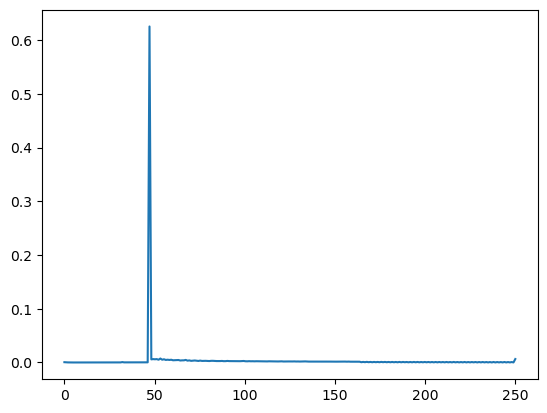

In [211]:
# 示例使用
Q = transQ_sparse(g)
psi0 = np.ones((n_k * n_z))/(n_k * n_z)
tol = 1e-5

ss = sparse_stationary_distribution_iteration(Q, psi0, tol)
a_dist=capital_marginal(ss)
plt.plot(kgrid,a_dist)

In [212]:
# ss = pristine_stationary_distribution_iteration(Q , psi0, tol)
# a_dist=capital_marginal(ss)
# plt.plot(kgrid,a_dist)

In [213]:
# Compute Demand and Supply in Capital Market
def capital_and_labor(w,r,tol):
    bound_matrix = capital_bound_matrix(w,r)
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r,bound_matrix)
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,tol)
    tmp = ss.reshape((n_k, n_z)) # joint stable distribution
    # capital_supply=np.dot(kgrid,a_dist)
    state_worker=np.ones((n_k, n_z))-state_entrepreneur
    R=r+delta
    ## compute demand and supply
    capital_demand_joint= np.zeros((n_k, n_z))    
    capital_supply_joint= np.zeros((n_k, n_z))
    labor_demand_joint= np.zeros((n_k, n_z))
    labor_supply_joint=np.zeros((n_k, n_z))            
    for i_k in range(n_k):
        for i_z in range(n_z):
            k = capital_demand(i_k,i_z,w,r,bound_matrix)*state_entrepreneur[i_k,i_z]
            capital_demand_joint[i_k,i_z]=tmp[i_k,i_z]*k
            l = (theta*zgrid[i_z]*(k**alpha)/w)**(1/(1-theta))
            labor_demand_joint[i_k,i_z]=tmp[i_k,i_z]*l          
            capital_supply_joint[i_k,i_z]=tmp[i_k,i_z]*g[i_k,i_z]
            labor_supply_joint[i_k,i_z]=state_worker[i_k,i_z]*tmp[i_k,i_z]
    capital_supply=np.sum(capital_supply_joint)
    labor_supply=np.sum(labor_supply_joint)
    k_demand=np.sum(capital_demand_joint)
    labor_demand=np.sum(labor_demand_joint)
    
    return capital_supply,k_demand,labor_supply,labor_demand

In [214]:
capital_and_labor(0.7,0.074,1e-4)

(70.24349669363032, 32.201114848334775, 0.8700787327630749, 10.435077614415944)

## solve equilibrium price $(w,r)$ setup

In [215]:
def equilibrium_k(w,r,tol):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r,tol)
    res_k = a_supply-a_demand
    print('w=',w,'r=',r,'capital supply=',a_supply,'capital demand=',a_demand,'res_k=',res_k)
    return res_k

def equilibrium_l(w,r,tol):
    a_supply,a_demand,l_supply,l_demand=capital_and_labor(w,r,tol)
    res_l=l_supply-l_demand
    print('w=',w,'r=',r,'labor suply=',l_supply,'labor demand=',l_demand,'res_l=',res_l)
    return res_l


In [216]:
import scipy.optimize as optimize

def w_update(r,tol):
    wmax=1.5
    wmin=0.5
    w0=1/2*(wmin+wmax)
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol:
        res = equilibrium_l(w0,r,1e-4)
        if res < 0:
            wmin=w0
        else:
            wmax=w0
        w0=1/2*(wmin+wmax)
        error = np.abs(wmax-wmin)
        count = count + 1
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    print("final w=", w0)
    return w0
    

In [217]:
# import scipy.optimize as optimize

# def w_update(r,tol):
#     wmax=1
#     wmin=0.3
#     w0=1/2*(wmin+wmax)
#     error = np.inf
#     count = 0
#     max_iter = 1000
#     print_skip = 50
#     while count < max_iter and error > tol:
#         res = equilibrium_l(w0,r,1e-4)
#         if res < 0:
#             wmin=w0
#         else:
#             wmax=w0
#         w0=1/2*(wmin+wmax)
#         error = np.abs(wmax-wmin)
#         count = count + 1
#     if error > tol:
#         print("Failed to converge!")
#     else:
#         print(f"\nConverged in {count} iterations.")
#     print("final w=", w0)
#     return w0
    

## plot

In [218]:
from tqdm import tqdm

def labor_curve(n_a, wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r,1e-4) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, l_supply, l_demand = labor_curve(
    n_a=n_k, wmin=0.5, wmax=1.5, wgrid_number=50,r=0.082
)


100%|██████████| 50/50 [01:35<00:00,  1.92s/it]


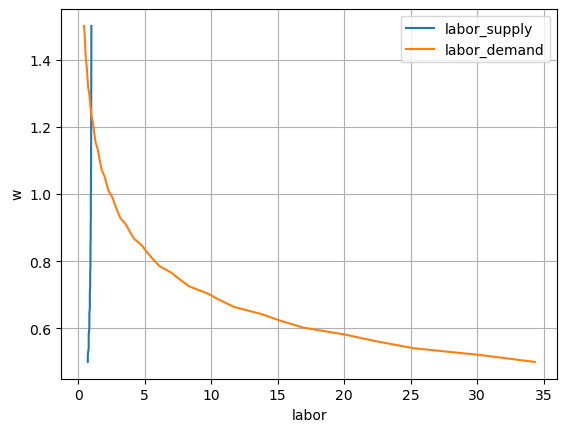

In [219]:
# Plot
plt.plot(l_supply,wgrid,label="labor_supply")
plt.plot(l_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.legend()
plt.grid(True)

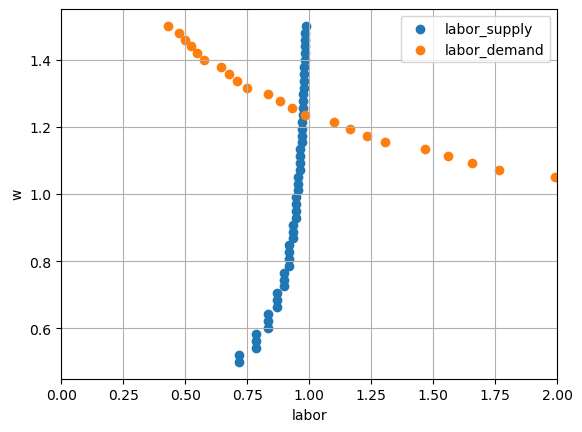

In [220]:
# plot
plt.scatter(l_supply,wgrid,label="labor_supply")
plt.scatter(l_demand,wgrid,label="labor_demand")
# plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.xlim(0,2)
plt.legend()
plt.grid(True)

In [221]:
l_supply-l_demand

array([-3.36131597e+01, -2.95336091e+01, -2.44342972e+01, -2.16456072e+01,
       -1.92449521e+01, -1.60924500e+01, -1.43921317e+01, -1.29059801e+01,
       -1.08693975e+01, -9.78797545e+00, -8.83064389e+00, -7.46544430e+00,
       -6.75247501e+00, -6.11471969e+00, -5.17185838e+00, -4.68875356e+00,
       -4.25224386e+00, -3.85871104e+00, -3.24739052e+00, -2.94178109e+00,
       -2.66528470e+00, -2.21867259e+00, -2.00147390e+00, -1.80262326e+00,
       -1.61990238e+00, -1.31242454e+00, -1.16764460e+00, -1.03373879e+00,
       -8.00805845e-01, -6.93644195e-01, -5.94421500e-01, -5.02694456e-01,
       -3.35659659e-01, -2.61550161e-01, -1.92671927e-01, -1.28684420e-01,
       -6.18562196e-03,  4.60999992e-02,  9.48298287e-02,  1.40327593e-01,
        2.31736558e-01,  2.69207473e-01,  3.04271433e-01,  3.37219170e-01,
        4.06648137e-01,  4.33836710e-01,  4.59488409e-01,  4.83631398e-01,
        5.06374675e-01,  5.57114936e-01])

In [222]:
wgrid

array([0.5       , 0.52040816, 0.54081633, 0.56122449, 0.58163265,
       0.60204082, 0.62244898, 0.64285714, 0.66326531, 0.68367347,
       0.70408163, 0.7244898 , 0.74489796, 0.76530612, 0.78571429,
       0.80612245, 0.82653061, 0.84693878, 0.86734694, 0.8877551 ,
       0.90816327, 0.92857143, 0.94897959, 0.96938776, 0.98979592,
       1.01020408, 1.03061224, 1.05102041, 1.07142857, 1.09183673,
       1.1122449 , 1.13265306, 1.15306122, 1.17346939, 1.19387755,
       1.21428571, 1.23469388, 1.25510204, 1.2755102 , 1.29591837,
       1.31632653, 1.33673469, 1.35714286, 1.37755102, 1.39795918,
       1.41836735, 1.43877551, 1.45918367, 1.47959184, 1.5       ])

In [223]:
equilibrium_k(0.76530612,0.082,1e-4)

w= 0.76530612 r= 0.082 capital supply= 138.82973802584107 capital demand= 22.786582893156748 res_k= 116.04315513268432


116.04315513268432

In [224]:
from tqdm import tqdm
# capital 之前 工资要稳定：劳动力市场要出清
def capital_curve(n_a, rmin, rmax, rgrid_number):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        w = w_update(r0,1e-3)
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0,1e-4) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, k_supply, k_demand = capital_curve(
    n_a=n_k, rmin=0.03, rmax=0.082, rgrid_number=50
)


  0%|          | 0/50 [00:00<?, ?it/s]

w= 1.0 r= 0.03 labor suply= 0.9797695644532007 labor demand= 2.2427139068308843 res_l= -1.2629443423776836
w= 1.25 r= 0.03 labor suply= 0.9886997461990299 labor demand= 0.9077751660877831 res_l= 0.08092458011124681
w= 1.125 r= 0.03 labor suply= 0.9855788735523934 labor demand= 1.396208768346935 res_l= -0.4106298947945417
w= 1.1875 r= 0.03 labor suply= 0.9878309492011967 labor demand= 1.0949692633237806 res_l= -0.1071383141225839
w= 1.21875 r= 0.03 labor suply= 0.9885677322367328 labor demand= 0.9916531495787155 res_l= -0.0030854173419827546
w= 1.234375 r= 0.03 labor suply= 0.988627403455016 labor demand= 0.9482456324647623 res_l= 0.04038177099025364
w= 1.2265625 r= 0.03 labor suply= 0.9885843140713267 labor demand= 0.9704775527541778 res_l= 0.018106761317148945
w= 1.22265625 r= 0.03 labor suply= 0.9885681556614997 labor demand= 0.9818773619607856 res_l= 0.006690793700714126
w= 1.220703125 r= 0.03 labor suply= 0.9885478365957294 labor demand= 0.9869981769858924 res_l= 0.0015496596098369

  2%|▏         | 1/50 [00:21<17:51, 21.88s/it]

w= 1.0 r= 0.031061224489795917 labor suply= 0.9799045839766782 labor demand= 2.2232490327994143 res_l= -1.243344448822736
w= 1.25 r= 0.031061224489795917 labor suply= 0.9886850733541378 labor demand= 0.9001390337985091 res_l= 0.08854603955562868
w= 1.125 r= 0.031061224489795917 labor suply= 0.9855738503583419 labor demand= 1.3843718265858231 res_l= -0.39879797622748125
w= 1.1875 r= 0.031061224489795917 labor suply= 0.9878292157839036 labor demand= 1.0847557075743859 res_l= -0.0969264917904823
w= 1.21875 r= 0.031061224489795917 labor suply= 0.9885438407695997 labor demand= 0.98398099442681 res_l= 0.004562846342789695
w= 1.203125 r= 0.031061224489795917 labor suply= 0.9881055045812145 labor demand= 1.0314288062748114 res_l= -0.04332330169359688
w= 1.2109375 r= 0.031061224489795917 labor suply= 0.9885327073756953 labor demand= 1.0041871575511632 res_l= -0.01565445017546785
w= 1.21484375 r= 0.031061224489795917 labor suply= 0.9885442983242136 labor demand= 0.993774501601953 res_l= -0.00523

  4%|▍         | 2/50 [00:42<16:57, 21.19s/it]

w= 1.0 r= 0.032122448979591836 labor suply= 0.9798325791316799 labor demand= 2.208253328348624 res_l= -1.2284207492169439
w= 1.25 r= 0.032122448979591836 labor suply= 0.9899764811657288 labor demand= 0.8455301261200165 res_l= 0.14444635504571224
w= 1.125 r= 0.032122448979591836 labor suply= 0.9855496891511106 labor demand= 1.3735895581138067 res_l= -0.38803986896269604
w= 1.1875 r= 0.032122448979591836 labor suply= 0.9878289552892785 labor demand= 1.0760067897601029 res_l= -0.08817783447082439
w= 1.21875 r= 0.032122448979591836 labor suply= 0.9885461206032358 labor demand= 0.9742284849253855 res_l= 0.014317635677850271
w= 1.203125 r= 0.032122448979591836 labor suply= 0.9884568565450156 labor demand= 1.018278493274614 res_l= -0.029821636729598477
w= 1.2109375 r= 0.032122448979591836 labor suply= 0.9885009826774722 labor demand= 0.996585877471834 res_l= -0.008084894794361808
w= 1.21484375 r= 0.032122448979591836 labor suply= 0.9885283945324834 labor demand= 0.9862166810376649 res_l= 0.00

  6%|▌         | 3/50 [01:03<16:28, 21.04s/it]

w= 1.0 r= 0.033183673469387755 labor suply= 0.9821664899504929 labor demand= 2.0652302127696185 res_l= -1.0830637228191256
w= 1.25 r= 0.033183673469387755 labor suply= 0.9900454249992979 labor demand= 0.8366451578613172 res_l= 0.15340026713798072
w= 1.125 r= 0.033183673469387755 labor suply= 0.9856863589028565 labor demand= 1.3566092780510668 res_l= -0.3709229191482103
w= 1.1875 r= 0.033183673469387755 labor suply= 0.9882307853848405 labor demand= 1.0620274420130709 res_l= -0.07379665662823032
w= 1.21875 r= 0.033183673469387755 labor suply= 0.9885184533589242 labor demand= 0.9655191147974374 res_l= 0.022999338561486837
w= 1.203125 r= 0.033183673469387755 labor suply= 0.988458238799407 labor demand= 1.010047887717929 res_l= -0.02158964891852211
w= 1.2109375 r= 0.033183673469387755 labor suply= 0.9884742694314974 labor demand= 0.9891304190135339 res_l= -0.0006561495820365248
w= 1.21484375 r= 0.033183673469387755 labor suply= 0.9884892468546976 labor demand= 0.9773104805573112 res_l= 0.01

  8%|▊         | 4/50 [01:24<16:01, 20.91s/it]

w= 1.0 r= 0.03424489795918367 labor suply= 0.9822154280613147 labor demand= 2.048775820496119 res_l= -1.0665603924348044
w= 1.25 r= 0.03424489795918367 labor suply= 0.9900354287975813 labor demand= 0.8288729540851729 res_l= 0.1611624747124084
w= 1.125 r= 0.03424489795918367 labor suply= 0.9856428274506095 labor demand= 1.3457378854137074 res_l= -0.36009505796309793
w= 1.1875 r= 0.03424489795918367 labor suply= 0.988346926443612 labor demand= 1.0475677902985536 res_l= -0.05922086385494163
w= 1.21875 r= 0.03424489795918367 labor suply= 0.9885058827176065 labor demand= 0.9575542695628955 res_l= 0.030951613154711066
w= 1.203125 r= 0.03424489795918367 labor suply= 0.9884289501905912 labor demand= 1.0022133895668615 res_l= -0.013784439376270274
w= 1.2109375 r= 0.03424489795918367 labor suply= 0.9884542304738895 labor demand= 0.979424285647694 res_l= 0.009029944826195457
w= 1.20703125 r= 0.03424489795918367 labor suply= 0.9884389610813406 labor demand= 0.9917123745643772 res_l= -0.00327341348

 10%|█         | 5/50 [01:44<15:36, 20.81s/it]

w= 1.0 r= 0.03530612244897959 labor suply= 0.983240962510895 labor demand= 2.0194456552920235 res_l= -1.0362046927811286
w= 1.25 r= 0.03530612244897959 labor suply= 0.9901283773561014 labor demand= 0.8183878964005722 res_l= 0.17174048095552918
w= 1.125 r= 0.03530612244897959 labor suply= 0.9856458799082066 labor demand= 1.3337058597596239 res_l= -0.34805997985141723
w= 1.1875 r= 0.03530612244897959 labor suply= 0.9883552465952722 labor demand= 1.03768513349967 res_l= -0.04932988690439777
w= 1.21875 r= 0.03530612244897959 labor suply= 0.9885083666679577 labor demand= 0.948635999218139 res_l= 0.0398723674498187
w= 1.203125 r= 0.03530612244897959 labor suply= 0.9884144068892828 labor demand= 0.9938950124471508 res_l= -0.005480605557868001
w= 1.2109375 r= 0.03530612244897959 labor suply= 0.9884453496555269 labor demand= 0.9714433458929403 res_l= 0.017002003762586537
w= 1.20703125 r= 0.03530612244897959 labor suply= 0.9884338236679995 labor demand= 0.9816288489553977 res_l= 0.00680497471260

 12%|█▏        | 6/50 [02:05<15:08, 20.65s/it]

w= 1.0 r= 0.03636734693877551 labor suply= 0.9831542150803823 labor demand= 2.0045258352059485 res_l= -1.0213716201255663
w= 1.25 r= 0.03636734693877551 labor suply= 0.9901250730751114 labor demand= 0.8111428815085016 res_l= 0.17898219156660988
w= 1.125 r= 0.03636734693877551 labor suply= 0.9856116821952712 labor demand= 1.3229580925236095 res_l= -0.33734641032833834
w= 1.1875 r= 0.03636734693877551 labor suply= 0.9883140615741932 labor demand= 1.0301247824775106 res_l= -0.04181072090331739
w= 1.21875 r= 0.03636734693877551 labor suply= 0.9884802598645056 labor demand= 0.9400069474808704 res_l= 0.04847331238363517
w= 1.203125 r= 0.03636734693877551 labor suply= 0.9884090033425578 labor demand= 0.983982694625027 res_l= 0.0044263087175308025
w= 1.1953125 r= 0.03636734693877551 labor suply= 0.9883509381693965 labor demand= 1.0077585665582423 res_l= -0.0194076283888458
w= 1.19921875 r= 0.03636734693877551 labor suply= 0.9883629426198115 labor demand= 0.9967063731653064 res_l= -0.0083434305

 14%|█▍        | 7/50 [02:25<14:42, 20.52s/it]

w= 1.0 r= 0.03742857142857143 labor suply= 0.983109772414924 labor demand= 1.9911572655401812 res_l= -1.0080474931252572
w= 1.25 r= 0.03742857142857143 labor suply= 0.9904093192052703 labor demand= 0.8004505738927225 res_l= 0.18995874531254786
w= 1.125 r= 0.03742857142857143 labor suply= 0.9855822723981287 labor demand= 1.3128372886232844 res_l= -0.32725501622515574
w= 1.1875 r= 0.03742857142857143 labor suply= 0.988315089521291 labor demand= 1.021681019064035 res_l= -0.03336592954274409
w= 1.21875 r= 0.03742857142857143 labor suply= 0.9884672480958846 labor demand= 0.9325718290786518 res_l= 0.05589541901723283
w= 1.203125 r= 0.03742857142857143 labor suply= 0.9883952295282125 labor demand= 0.976261189428786 res_l= 0.012134040099426424
w= 1.1953125 r= 0.03742857142857143 labor suply= 0.9883189238729944 labor demand= 0.9993596326956966 res_l= -0.01104070882270225
w= 1.19921875 r= 0.03742857142857143 labor suply= 0.9883660049505847 labor demand= 0.9872947558332905 res_l= 0.00107124911729

 16%|█▌        | 8/50 [02:45<14:20, 20.48s/it]

w= 1.0 r= 0.03848979591836735 labor suply= 0.9830464345956226 labor demand= 1.9760171196246892 res_l= -0.9929706850290666
w= 1.25 r= 0.03848979591836735 labor suply= 0.9903901973436802 labor demand= 0.7940390393441497 res_l= 0.1963511579995305
w= 1.125 r= 0.03848979591836735 labor suply= 0.9855480733515932 labor demand= 1.3030947338512635 res_l= -0.3175466604996703
w= 1.1875 r= 0.03848979591836735 labor suply= 0.9882769309906861 labor demand= 1.013336205662593 res_l= -0.025059274671906828
w= 1.21875 r= 0.03848979591836735 labor suply= 0.9885379154729179 labor demand= 0.9233073285583826 res_l= 0.06523058691453532
w= 1.203125 r= 0.03848979591836735 labor suply= 0.9883792961556073 labor demand= 0.9680168314519798 res_l= 0.02036246470362746
w= 1.1953125 r= 0.03848979591836735 labor suply= 0.9882973066801871 labor demand= 0.9909291533034655 res_l= -0.002631846623278422
w= 1.19921875 r= 0.03848979591836735 labor suply= 0.9883510678310616 labor demand= 0.979297088449796 res_l= 0.0090539793812

 18%|█▊        | 9/50 [03:06<14:00, 20.49s/it]

w= 1.0 r= 0.039551020408163266 labor suply= 0.9829704621837738 labor demand= 1.9623195272694929 res_l= -0.9793490650857191
w= 1.25 r= 0.039551020408163266 labor suply= 0.9903683841547104 labor demand= 0.7876044288447025 res_l= 0.2027639553100079
w= 1.125 r= 0.039551020408163266 labor suply= 0.9856332764523438 labor demand= 1.2905597283744503 res_l= -0.30492645192210655
w= 1.1875 r= 0.039551020408163266 labor suply= 0.9882606063520838 labor demand= 1.0049055148179065 res_l= -0.016644908465822672
w= 1.21875 r= 0.039551020408163266 labor suply= 0.988510903204477 labor demand= 0.9149523659574248 res_l= 0.07355853724705219
w= 1.203125 r= 0.039551020408163266 labor suply= 0.9883619663593084 labor demand= 0.9584819640023869 res_l= 0.029880002356921453
w= 1.1953125 r= 0.039551020408163266 labor suply= 0.9882815382308984 labor demand= 0.9824485594042586 res_l= 0.005832978826639801
w= 1.19140625 r= 0.039551020408163266 labor suply= 0.9882776613864874 labor demand= 0.9934412326305617 res_l= -0.00

 20%|██        | 10/50 [03:27<13:44, 20.61s/it]

w= 1.0 r= 0.040612244897959185 labor suply= 0.9828760962405793 labor demand= 1.9498572397620215 res_l= -0.9669811435214423
w= 1.25 r= 0.040612244897959185 labor suply= 0.9903424637242052 labor demand= 0.7808055442713571 res_l= 0.20953691945284814
w= 1.125 r= 0.040612244897959185 labor suply= 0.9855990896991618 labor demand= 1.2797500522439993 res_l= -0.2941509625448375
w= 1.1875 r= 0.040612244897959185 labor suply= 0.9882399406793854 labor demand= 0.9961733417686048 res_l= -0.007933401089219472
w= 1.21875 r= 0.040612244897959185 labor suply= 0.9885157309564989 labor demand= 0.9065082731030472 res_l= 0.08200745785345176
w= 1.203125 r= 0.040612244897959185 labor suply= 0.9884051684839955 labor demand= 0.9487526887245818 res_l= 0.03965247975941366
w= 1.1953125 r= 0.040612244897959185 labor suply= 0.9882627667608057 labor demand= 0.973470594868752 res_l= 0.01479217189205373
w= 1.19140625 r= 0.040612244897959185 labor suply= 0.988269245208474 labor demand= 0.9844220258134384 res_l= 0.003847

 22%|██▏       | 11/50 [03:47<13:22, 20.59s/it]

w= 1.0 r= 0.041673469387755104 labor suply= 0.9827893327119068 labor demand= 1.936209349970985 res_l= -0.9534200172590781
w= 1.25 r= 0.041673469387755104 labor suply= 0.9903197761597266 labor demand= 0.7736429751557206 res_l= 0.216676801004006
w= 1.125 r= 0.041673469387755104 labor suply= 0.9855919779600445 labor demand= 1.2686927696160675 res_l= -0.283100791656023
w= 1.1875 r= 0.041673469387755104 labor suply= 0.9882161190828834 labor demand= 0.9874359040207112 res_l= 0.0007802150621721848
w= 1.15625 r= 0.041673469387755104 labor suply= 0.9878977325073097 labor demand= 1.0885450259605338 res_l= -0.1006472934532241
w= 1.171875 r= 0.041673469387755104 labor suply= 0.9881361698278399 labor demand= 1.0337207700765927 res_l= -0.04558460024875277
w= 1.1796875 r= 0.041673469387755104 labor suply= 0.9881544051366659 labor demand= 1.0114549860492585 res_l= -0.023300580912592683
w= 1.18359375 r= 0.041673469387755104 labor suply= 0.9881855712598369 labor demand= 0.99947450589874 res_l= -0.011288

 24%|██▍       | 12/50 [04:08<13:00, 20.55s/it]

w= 1.0 r= 0.04273469387755102 labor suply= 0.982761601417063 labor demand= 1.9213257441226093 res_l= -0.9385641427055462
w= 1.25 r= 0.04273469387755102 labor suply= 0.9903303546372316 labor demand= 0.7660258925949062 res_l= 0.22430446204232546
w= 1.125 r= 0.04273469387755102 labor suply= 0.986174573035982 labor demand= 1.2501194874983792 res_l= -0.2639449144623972
w= 1.1875 r= 0.04273469387755102 labor suply= 0.9881984289119947 labor demand= 0.9790069557819081 res_l= 0.009191473130086614
w= 1.15625 r= 0.04273469387755102 labor suply= 0.9878597076182066 labor demand= 1.07974108882105 res_l= -0.09188138120284328
w= 1.171875 r= 0.04273469387755102 labor suply= 0.9880936585332021 labor demand= 1.0258295976968912 res_l= -0.037735939163689114
w= 1.1796875 r= 0.04273469387755102 labor suply= 0.9881619295418294 labor demand= 1.0017963416513251 res_l= -0.013634412109495786
w= 1.18359375 r= 0.04273469387755102 labor suply= 0.9881719433543227 labor demand= 0.9900993350110993 res_l= -0.00192739165

 26%|██▌       | 13/50 [04:29<12:45, 20.69s/it]

w= 1.0 r= 0.043795918367346934 labor suply= 0.982637352719299 labor demand= 1.9089328652593853 res_l= -0.9262955125400864
w= 1.25 r= 0.043795918367346934 labor suply= 0.9903177025846579 labor demand= 0.7584688391775946 res_l= 0.23184886340706334
w= 1.125 r= 0.043795918367346934 labor suply= 0.9861269968976576 labor demand= 1.2405768859407722 res_l= -0.2544498890431146
w= 1.1875 r= 0.043795918367346934 labor suply= 0.9882571146244075 labor demand= 0.9691211575195562 res_l= 0.019135957104851276
w= 1.15625 r= 0.043795918367346934 labor suply= 0.9878457414224576 labor demand= 1.0696123985166044 res_l= -0.08176665709414677
w= 1.171875 r= 0.043795918367346934 labor suply= 0.988052819035652 labor demand= 1.017957967254027 res_l= -0.02990514821837509
w= 1.1796875 r= 0.043795918367346934 labor suply= 0.9881190103115302 labor demand= 0.9932402187835174 res_l= -0.005121208471987271
w= 1.18359375 r= 0.043795918367346934 labor suply= 0.9881457696966341 labor demand= 0.9822758308746409 res_l= 0.0058

 28%|██▊       | 14/50 [04:50<12:32, 20.89s/it]

w= 1.0 r= 0.04485714285714286 labor suply= 0.982619394789588 labor demand= 1.8929219000219373 res_l= -0.9103025052323492
w= 1.25 r= 0.04485714285714286 labor suply= 0.990299296988138 labor demand= 0.7518835220256578 res_l= 0.23841577496248023
w= 1.125 r= 0.04485714285714286 labor suply= 0.9860983537132978 labor demand= 1.2287874895809892 res_l= -0.24268913586769136
w= 1.1875 r= 0.04485714285714286 labor suply= 0.9882339368009012 labor demand= 0.9605837299165441 res_l= 0.027650206884357154
w= 1.15625 r= 0.04485714285714286 labor suply= 0.9879455280400911 labor demand= 1.056338097623565 res_l= -0.06839256958347395
w= 1.171875 r= 0.04485714285714286 labor suply= 0.9880487842955746 labor demand= 1.0084469896175081 res_l= -0.020398205321933482
w= 1.1796875 r= 0.04485714285714286 labor suply= 0.9881859766686591 labor demand= 0.9841055958294445 res_l= 0.004080380839214692
w= 1.17578125 r= 0.04485714285714286 labor suply= 0.9880893304115504 labor demand= 0.9958109202869059 res_l= -0.0077215898

 30%|███       | 15/50 [05:11<12:07, 20.80s/it]

w= 1.0 r= 0.04591836734693877 labor suply= 0.9825315475728562 labor demand= 1.8801587803004596 res_l= -0.8976272327276034
w= 1.25 r= 0.04591836734693877 labor suply= 0.9902632096292747 labor demand= 0.7462513593460696 res_l= 0.24401185028320516
w= 1.125 r= 0.04591836734693877 labor suply= 0.9860528449897351 labor demand= 1.2190637228422858 res_l= -0.2330108778525507
w= 1.1875 r= 0.04591836734693877 labor suply= 0.988639641582442 labor demand= 0.9465326332145478 res_l= 0.04210700836789416
w= 1.15625 r= 0.04591836734693877 labor suply= 0.9879218101926602 labor demand= 1.047686238574232 res_l= -0.05976442838157181
w= 1.171875 r= 0.04591836734693877 labor suply= 0.9880318104785697 labor demand= 0.9995843507157198 res_l= -0.011552540237150133
w= 1.1796875 r= 0.04591836734693877 labor suply= 0.9881608418321448 labor demand= 0.9749054265443579 res_l= 0.013255415287786954
w= 1.17578125 r= 0.04591836734693877 labor suply= 0.9881309051886207 labor demand= 0.9870926647866982 res_l= 0.001038240401

 32%|███▏      | 16/50 [05:31<11:45, 20.76s/it]

w= 1.0 r= 0.046979591836734697 labor suply= 0.9824805729634689 labor demand= 1.8667508650285063 res_l= -0.8842702920650374
w= 1.25 r= 0.046979591836734697 labor suply= 0.9902572079602535 labor demand= 0.7391869853919797 res_l= 0.2510702225682738
w= 1.125 r= 0.046979591836734697 labor suply= 0.9860276104268498 labor demand= 1.2093014966218087 res_l= -0.22327388619495891
w= 1.1875 r= 0.046979591836734697 labor suply= 0.9886100774091735 labor demand= 0.9391711750029585 res_l= 0.04943890240621496
w= 1.15625 r= 0.046979591836734697 labor suply= 0.9878914484758821 labor demand= 1.039368620219275 res_l= -0.051477171743392836
w= 1.171875 r= 0.046979591836734697 labor suply= 0.9880868878496578 labor demand= 0.9899553147851878 res_l= -0.001868426935530021
w= 1.1796875 r= 0.046979591836734697 labor suply= 0.9885809102736058 labor demand= 0.9613107398045335 res_l= 0.02727017046907232
w= 1.17578125 r= 0.046979591836734697 labor suply= 0.9881169398800072 labor demand= 0.977977416087037 res_l= 0.0101

 34%|███▍      | 17/50 [05:53<11:36, 21.10s/it]

w= 1.0 r= 0.04804081632653061 labor suply= 0.9826095660260763 labor demand= 1.8497190817295426 res_l= -0.8671095157034663
w= 1.25 r= 0.04804081632653061 labor suply= 0.9903025961671741 labor demand= 0.7312881929693653 res_l= 0.2590144031978088
w= 1.125 r= 0.04804081632653061 labor suply= 0.9859877041109164 labor demand= 1.199200659950184 res_l= -0.2132129558392677
w= 1.1875 r= 0.04804081632653061 labor suply= 0.9885955069037896 labor demand= 0.9303090448451521 res_l= 0.05828646205863752
w= 1.15625 r= 0.04804081632653061 labor suply= 0.9878453540958508 labor demand= 1.0312062617726765 res_l= -0.043360907676825655
w= 1.171875 r= 0.04804081632653061 labor suply= 0.9880774985881559 labor demand= 0.9812467227328805 res_l= 0.006830775855275362
w= 1.1640625 r= 0.04804081632653061 labor suply= 0.9879921461774402 labor demand= 1.0055528707402963 res_l= -0.017560724562856067
w= 1.16796875 r= 0.04804081632653061 labor suply= 0.9880491191837358 labor demand= 0.9928951372160265 res_l= -0.0048460180

 36%|███▌      | 18/50 [06:14<11:11, 20.98s/it]

w= 1.0 r= 0.049102040816326534 labor suply= 0.983667926208601 labor demand= 1.821438432601273 res_l= -0.8377705063926719
w= 1.25 r= 0.049102040816326534 labor suply= 0.990267159648544 labor demand= 0.7253834868117327 res_l= 0.26488367283681125
w= 1.125 r= 0.049102040816326534 labor suply= 0.9859336993699512 labor demand= 1.1888145022682268 res_l= -0.2028808028982756
w= 1.1875 r= 0.049102040816326534 labor suply= 0.9885515677591299 labor demand= 0.9224801101149349 res_l= 0.06607145764419498
w= 1.15625 r= 0.049102040816326534 labor suply= 0.9878420724057507 labor demand= 1.021807382759015 res_l= -0.03396531035326433
w= 1.171875 r= 0.049102040816326534 labor suply= 0.9884859398256236 labor demand= 0.967716767046972 res_l= 0.020769172778651646
w= 1.1640625 r= 0.049102040816326534 labor suply= 0.9880002892093862 labor demand= 0.9962146347762406 res_l= -0.008214345566854409
w= 1.16796875 r= 0.049102040816326534 labor suply= 0.9884694042489022 labor demand= 0.9797823391590645 res_l= 0.0086870

 38%|███▊      | 19/50 [06:35<10:49, 20.95s/it]

w= 1.0 r= 0.050163265306122445 labor suply= 0.9650489712729852 labor demand= 2.4399471407883424 res_l= -1.4748981695153573
w= 1.25 r= 0.050163265306122445 labor suply= 0.9905584983344041 labor demand= 0.7151887380952717 res_l= 0.2753697602391324
w= 1.125 r= 0.050163265306122445 labor suply= 0.9858971032333714 labor demand= 1.179245272704946 res_l= -0.19334816947157463
w= 1.1875 r= 0.050163265306122445 labor suply= 0.9885160362815908 labor demand= 0.9152311300844644 res_l= 0.07328490619712635
w= 1.15625 r= 0.050163265306122445 labor suply= 0.9878984831597546 labor demand= 1.0119828353624396 res_l= -0.02408435220268501
w= 1.171875 r= 0.050163265306122445 labor suply= 0.9884445807898369 labor demand= 0.9596069701224542 res_l= 0.028837610667382663
w= 1.1640625 r= 0.050163265306122445 labor suply= 0.9884302978812893 labor demand= 0.9828418904026737 res_l= 0.0055884074786156646
w= 1.16015625 r= 0.050163265306122445 labor suply= 0.988417478454454 labor demand= 0.9938570672342951 res_l= -0.005

 40%|████      | 20/50 [06:56<10:27, 20.91s/it]

w= 1.0 r= 0.05122448979591837 labor suply= 0.9649962558622225 labor demand= 2.4201228542396622 res_l= -1.4551265983774397
w= 1.25 r= 0.05122448979591837 labor suply= 0.9905446783957854 labor demand= 0.7084211178306845 res_l= 0.2821235605651009
w= 1.125 r= 0.05122448979591837 labor suply= 0.9874195131436327 labor demand= 1.1117972771113394 res_l= -0.12437776396770661
w= 1.1875 r= 0.05122448979591837 labor suply= 0.988493534770073 labor demand= 0.9070211741535583 res_l= 0.08147236061651464
w= 1.15625 r= 0.05122448979591837 labor suply= 0.9883610041066342 labor demand= 0.9974389513079627 res_l= -0.009077947201328485
w= 1.171875 r= 0.05122448979591837 labor suply= 0.988439317517257 labor demand= 0.9506397448076763 res_l= 0.037799572709580676
w= 1.1640625 r= 0.05122448979591837 labor suply= 0.9883769343200937 labor demand= 0.9740271867953652 res_l= 0.014349747524728507
w= 1.16015625 r= 0.05122448979591837 labor suply= 0.9883762736710091 labor demand= 0.9861403971269674 res_l= 0.002235876544

 42%|████▏     | 21/50 [07:16<10:05, 20.86s/it]

w= 1.0 r= 0.05228571428571428 labor suply= 0.9590940308150627 labor demand= 2.539511185585884 res_l= -1.5804171547708212
w= 1.25 r= 0.05228571428571428 labor suply= 0.9905239290103339 labor demand= 0.701766747585088 res_l= 0.288757181425246
w= 1.125 r= 0.05228571428571428 labor suply= 0.9817110352306971 labor demand= 1.2942995774454953 res_l= -0.31258854221479815
w= 1.1875 r= 0.05228571428571428 labor suply= 0.9897542677968965 labor demand= 0.85313383048568 res_l= 0.13662043731121642
w= 1.15625 r= 0.05228571428571428 labor suply= 0.9883204966432203 labor demand= 0.9897444175884231 res_l= -0.0014239209452028279
w= 1.171875 r= 0.05228571428571428 labor suply= 0.9883834118304151 labor demand= 0.9432849546700549 res_l= 0.045098457160360206
w= 1.1640625 r= 0.05228571428571428 labor suply= 0.9883372146056167 labor demand= 0.9661191553659205 res_l= 0.02221805923969622
w= 1.16015625 r= 0.05228571428571428 labor suply= 0.9883396249526868 labor demand= 0.9772174071251066 res_l= 0.011122217827580

 44%|████▍     | 22/50 [07:37<09:45, 20.92s/it]

w= 1.0 r= 0.05334693877551021 labor suply= 0.9524786510807173 labor demand= 2.6606326695932916 res_l= -1.7081540185125743
w= 1.25 r= 0.05334693877551021 labor suply= 0.990497982447722 labor demand= 0.6952617180028482 res_l= 0.29523626444487383
w= 1.125 r= 0.05334693877551021 labor suply= 0.975734565076935 labor demand= 1.4294075840455411 res_l= -0.4536730189686061
w= 1.1875 r= 0.05334693877551021 labor suply= 0.9850338482409331 labor demand= 0.9987193467262067 res_l= -0.013685498485273562
w= 1.21875 r= 0.05334693877551021 labor suply= 0.9899772424965672 labor demand= 0.767487638607202 res_l= 0.22248960388936512
w= 1.203125 r= 0.05334693877551021 labor suply= 0.9898811721025421 labor demand= 0.8045219634027674 res_l= 0.18535920869977474
w= 1.1953125 r= 0.05334693877551021 labor suply= 0.9801572709814844 labor demand= 1.0909378160431915 res_l= -0.11078054506170709
w= 1.19921875 r= 0.05334693877551021 labor suply= 0.9898713482886836 labor demand= 0.8137680139262159 res_l= 0.17610333436246

 46%|████▌     | 23/50 [07:58<09:25, 20.94s/it]

w= 1.0 r= 0.05440816326530612 labor suply= 0.9445709621307111 labor demand= 2.778580472227509 res_l= -1.8340095100967977
w= 1.25 r= 0.05440816326530612 labor suply= 0.9875216744413678 labor demand= 0.7785204583114562 res_l= 0.20900121612991163
w= 1.125 r= 0.05440816326530612 labor suply= 0.9676844717946225 labor demand= 1.5638400332194942 res_l= -0.5961555614248717
w= 1.1875 r= 0.05440816326530612 labor suply= 0.9800725708507056 labor demand= 1.1077849883246584 res_l= -0.1277124174739528
w= 1.21875 r= 0.05440816326530612 labor suply= 0.9776322898416062 labor demand= 1.0648578878379176 res_l= -0.08722559799631135
w= 1.234375 r= 0.05440816326530612 labor suply= 0.9874656590965758 labor demand= 0.8156719388852575 res_l= 0.17179372021131833
w= 1.2265625 r= 0.05440816326530612 labor suply= 0.9874278837129715 labor demand= 0.8361620697042987 res_l= 0.15126581400867278
w= 1.22265625 r= 0.05440816326530612 labor suply= 0.9874179169013402 labor demand= 0.8452901061180476 res_l= 0.14212781078329

 48%|████▊     | 24/50 [08:19<09:04, 20.95s/it]

w= 1.0 r= 0.05546938775510204 labor suply= 0.9437166001805056 labor demand= 2.7932629524533525 res_l= -1.849546352272847
w= 1.25 r= 0.05546938775510204 labor suply= 0.983492350799121 labor demand= 0.8652393255821069 res_l= 0.11825302521701408
w= 1.125 r= 0.05546938775510204 labor suply= 0.9669778276438076 labor demand= 1.5805916133193882 res_l= -0.6136137856755807
w= 1.1875 r= 0.05546938775510204 labor suply= 0.9734183363181776 labor demand= 1.2146173976046142 res_l= -0.24119906128643653
w= 1.21875 r= 0.05546938775510204 labor suply= 0.9775704754709015 labor demand= 1.057169856432486 res_l= -0.07959938096158459
w= 1.234375 r= 0.05546938775510204 labor suply= 0.9811148154858362 labor demand= 0.9451847998531938 res_l= 0.03593001563264242
w= 1.2265625 r= 0.05546938775510204 labor suply= 0.9775906724524719 labor demand= 1.0335554260020603 res_l= -0.05596475354958841
w= 1.23046875 r= 0.05546938775510204 labor suply= 0.9776030124573273 labor demand= 1.0212073304899376 res_l= -0.0436043180326

 50%|█████     | 25/50 [08:40<08:43, 20.93s/it]

w= 1.0 r= 0.05653061224489796 labor suply= 0.9436383572323412 labor demand= 2.8001582578688176 res_l= -1.8565199006364763
w= 1.25 r= 0.05653061224489796 labor suply= 0.977956304164148 labor demand= 0.9514323376309585 res_l= 0.026523966533189558
w= 1.125 r= 0.05653061224489796 labor suply= 0.9624013661250904 labor demand= 1.6668967193968924 res_l= -0.704495353271802
w= 1.1875 r= 0.05653061224489796 labor suply= 0.9681020421120653 labor demand= 1.304496801695078 res_l= -0.3363947595830127
w= 1.21875 r= 0.05653061224489796 labor suply= 0.973902980224483 labor demand= 1.1108815327554102 res_l= -0.13697855253092728
w= 1.234375 r= 0.05653061224489796 labor suply= 0.9739585821430884 labor demand= 1.0620994809666524 res_l= -0.08814089882356402
w= 1.2421875 r= 0.05653061224489796 labor suply= 0.9739692845831994 labor demand= 1.03800064109319 res_l= -0.06403135650999048
w= 1.24609375 r= 0.05653061224489796 labor suply= 0.9739766723059496 labor demand= 1.0268733730902813 res_l= -0.052896700784331

 52%|█████▏    | 26/50 [09:01<08:22, 20.94s/it]

w= 1.0 r= 0.057591836734693876 labor suply= 0.9337966408005792 labor demand= 2.9320594915087215 res_l= -1.9982628507081421
w= 1.25 r= 0.057591836734693876 labor suply= 0.9735805345995181 labor demand= 1.024518614180552 res_l= -0.05093807958103391
w= 1.375 r= 0.057591836734693876 labor suply= 0.9844004266157625 labor demand= 0.6033218584752564 res_l= 0.3810785681405061
w= 1.3125 r= 0.057591836734693876 labor suply= 0.9783368491391342 labor demand= 0.8025763651231353 res_l= 0.17576048401599886
w= 1.28125 r= 0.057591836734693876 labor suply= 0.9777889141903944 labor demand= 0.8801311750981786 res_l= 0.09765773909221576
w= 1.265625 r= 0.057591836734693876 labor suply= 0.9736326451144607 labor demand= 0.981956380335375 res_l= -0.008323735220914341
w= 1.2734375 r= 0.057591836734693876 labor suply= 0.9774036732732009 labor demand= 0.9029142521523207 res_l= 0.0744894211208802
w= 1.26953125 r= 0.057591836734693876 labor suply= 0.9740966693006439 labor demand= 0.9510678501706361 res_l= 0.0230288

 54%|█████▍    | 27/50 [09:22<08:03, 21.00s/it]

w= 1.0 r= 0.058653061224489794 labor suply= 0.9338021153648395 labor demand= 2.932519897597955 res_l= -1.9987177822331157
w= 1.25 r= 0.058653061224489794 labor suply= 0.9695803206386404 labor demand= 1.0738916317462321 res_l= -0.10431131110759173
w= 1.375 r= 0.058653061224489794 labor suply= 0.9818553741572476 labor demand= 0.6382271044992959 res_l= 0.3436282696579517
w= 1.3125 r= 0.058653061224489794 labor suply= 0.974690421963619 labor demand= 0.8458197472787073 res_l= 0.12887067468491165
w= 1.28125 r= 0.058653061224489794 labor suply= 0.9742274092438435 labor demand= 0.9383692001173997 res_l= 0.035858209126443885
w= 1.265625 r= 0.058653061224489794 labor suply= 0.9696434844287104 labor demand= 1.031371372753016 res_l= -0.061727888324305646
w= 1.2734375 r= 0.058653061224489794 labor suply= 0.9696923387933861 labor demand= 1.0072979654717114 res_l= -0.03760562667832523
w= 1.27734375 r= 0.058653061224489794 labor suply= 0.9698539117510298 labor demand= 0.9946967814578636 res_l= -0.0248

 56%|█████▌    | 28/50 [09:43<07:41, 20.99s/it]

w= 1.0 r= 0.05971428571428571 labor suply= 0.933800752251862 labor demand= 2.9358945051941507 res_l= -2.002093752942289
w= 1.25 r= 0.05971428571428571 labor suply= 0.9690924787906025 labor demand= 1.0829390604592997 res_l= -0.11384658166869721
w= 1.375 r= 0.05971428571428571 labor suply= 0.9784773423541606 labor demand= 0.6876053543617064 res_l= 0.2908719879924542
w= 1.3125 r= 0.05971428571428571 labor suply= 0.9742565611757908 labor demand= 0.8645382377628616 res_l= 0.1097183234129292
w= 1.28125 r= 0.05971428571428571 labor suply= 0.9702551658623295 labor demand= 0.9844879980169065 res_l= -0.014232832154576935
w= 1.296875 r= 0.05971428571428571 labor suply= 0.9702615248807425 labor demand= 0.9436886312707644 res_l= 0.026572893609978054
w= 1.2890625 r= 0.05971428571428571 labor suply= 0.9702608231515296 labor demand= 0.9636902296947185 res_l= 0.006570593456811102
w= 1.28515625 r= 0.05971428571428571 labor suply= 0.9702554459891242 labor demand= 0.9748377943707307 res_l= -0.004582348381

 58%|█████▊    | 29/50 [10:04<07:21, 21.05s/it]

w= 1.0 r= 0.06077551020408163 labor suply= 0.9337999770026519 labor demand= 2.956539899229713 res_l= -2.0227399222270614
w= 1.25 r= 0.06077551020408163 labor suply= 0.9690427331483683 labor demand= 1.0976439226215147 res_l= -0.12860118947314636
w= 1.375 r= 0.06077551020408163 labor suply= 0.9751937087812775 labor demand= 0.7232406825115583 res_l= 0.25195302626971927
w= 1.3125 r= 0.06077551020408163 labor suply= 0.9742375012870548 labor demand= 0.8679547272728215 res_l= 0.10628277401423325
w= 1.28125 r= 0.06077551020408163 labor suply= 0.9697674157853632 labor demand= 1.0015846751119748 res_l= -0.03181725932661161
w= 1.296875 r= 0.06077551020408163 labor suply= 0.9702673088821049 labor demand= 0.9449066170182902 res_l= 0.025360691863814733
w= 1.2890625 r= 0.06077551020408163 labor suply= 0.969772248548619 labor demand= 0.9702084025416016 res_l= -0.00043615399298257973
w= 1.29296875 r= 0.06077551020408163 labor suply= 0.9697722530652418 labor demand= 0.9605640657235444 res_l= 0.009208187

 60%|██████    | 30/50 [10:26<07:01, 21.05s/it]

w= 1.0 r= 0.06183673469387755 labor suply= 0.933805854518801 labor demand= 2.951883677738124 res_l= -2.018077823219323
w= 1.25 r= 0.06183673469387755 labor suply= 0.9690296891926945 labor demand= 1.1061625770628107 res_l= -0.13713288787011624
w= 1.375 r= 0.06183673469387755 labor suply= 0.9747886947606205 labor demand= 0.7353392524982632 res_l= 0.23944944226235731
w= 1.3125 r= 0.06183673469387755 labor suply= 0.9697974015359431 labor demand= 0.9199874679663543 res_l= 0.04980993356958874
w= 1.28125 r= 0.06183673469387755 labor suply= 0.9697717502886489 labor demand= 0.9999971075382188 res_l= -0.030225357249569873
w= 1.296875 r= 0.06183673469387755 labor suply= 0.9697794470548569 labor demand= 0.959918254817629 res_l= 0.009861192237227812
w= 1.2890625 r= 0.06183673469387755 labor suply= 0.9697717645683246 labor demand= 0.9789012950666516 res_l= -0.009129530498326988
w= 1.29296875 r= 0.06183673469387755 labor suply= 0.9697783557056205 labor demand= 0.9691302692016537 res_l= 0.000648086503

 62%|██████▏   | 31/50 [10:47<06:41, 21.12s/it]

w= 1.0 r= 0.06289795918367347 labor suply= 0.9337550726506236 labor demand= 2.96113165244295 res_l= -2.0273765797923264
w= 1.25 r= 0.06289795918367347 labor suply= 0.9690333333573145 labor demand= 1.103744493935904 res_l= -0.13471116057858956
w= 1.375 r= 0.06289795918367347 labor suply= 0.974794814795285 labor demand= 0.7365041884868939 res_l= 0.23829062630839104
w= 1.3125 r= 0.06289795918367347 labor suply= 0.9698023926205223 labor demand= 0.920443626644077 res_l= 0.049358765976445285
w= 1.28125 r= 0.06289795918367347 labor suply= 0.9697714263644782 labor demand= 1.005873881830265 res_l= -0.03610245546578683
w= 1.296875 r= 0.06289795918367347 labor suply= 0.9697838413376177 labor demand= 0.9674056164453735 res_l= 0.002378224892244263
w= 1.2890625 r= 0.06289795918367347 labor suply= 0.9697778244577608 labor demand= 0.9870765220458243 res_l= -0.01729869758806346
w= 1.29296875 r= 0.06289795918367347 labor suply= 0.9697779209981028 labor demand= 0.9769474002088817 res_l= -0.00716947921077

 64%|██████▍   | 32/50 [11:08<06:19, 21.06s/it]

w= 1.0 r= 0.0639591836734694 labor suply= 0.9338466015189165 labor demand= 2.9595565230442444 res_l= -2.025709921525328
w= 1.25 r= 0.0639591836734694 labor suply= 0.9697632396235089 labor demand= 1.1010634264314496 res_l= -0.13130018680794076
w= 1.375 r= 0.0639591836734694 labor suply= 0.9747945642030135 labor demand= 0.7429962155558714 res_l= 0.2317983486471421
w= 1.3125 r= 0.0639591836734694 labor suply= 0.96980901952056 labor demand= 0.9300751070233251 res_l= 0.0397339124972349
w= 1.28125 r= 0.0639591836734694 labor suply= 0.9697770817041323 labor demand= 1.01494455704575 res_l= -0.04516747534161769
w= 1.296875 r= 0.0639591836734694 labor suply= 0.9697937037042667 labor demand= 0.9664027977328823 res_l= 0.0033909059713843615
w= 1.2890625 r= 0.0639591836734694 labor suply= 0.969781977262484 labor demand= 0.9955964143200771 res_l= -0.02581443705759301
w= 1.29296875 r= 0.0639591836734694 labor suply= 0.9697891058485076 labor demand= 0.9763022140175519 res_l= -0.006513108169044268
w= 1.

 66%|██████▌   | 33/50 [11:29<05:58, 21.12s/it]

w= 1.0 r= 0.0650204081632653 labor suply= 0.9461069520211598 labor demand= 2.7810658928182517 res_l= -1.8349589407970919
w= 1.25 r= 0.0650204081632653 labor suply= 0.9697652618790004 labor demand= 1.1062056093219514 res_l= -0.13644034744295108
w= 1.375 r= 0.0650204081632653 labor suply= 0.9747997362778127 labor demand= 0.7487645146142746 res_l= 0.22603522166353807
w= 1.3125 r= 0.0650204081632653 labor suply= 0.9698124909451249 labor demand= 0.9365914782756188 res_l= 0.033221012669506056
w= 1.28125 r= 0.0650204081632653 labor suply= 0.9697766099767648 labor demand= 1.0210754529575248 res_l= -0.05129884298075993
w= 1.296875 r= 0.0650204081632653 labor suply= 0.969800666823599 labor demand= 0.9750505099521122 res_l= -0.005249843128513176
w= 1.3046875 r= 0.0650204081632653 labor suply= 0.969800678372098 labor demand= 0.9556819392068923 res_l= 0.014118739165205785
w= 1.30078125 r= 0.0650204081632653 labor suply= 0.9698006688437891 labor demand= 0.964585890509425 res_l= 0.005214778334364123


 68%|██████▊   | 34/50 [11:50<05:37, 21.07s/it]

w= 1.0 r= 0.06608163265306122 labor suply= 0.9461055193324156 labor demand= 2.7691408283340593 res_l= -1.8230353090016438
w= 1.25 r= 0.06608163265306122 labor suply= 0.9697645224072203 labor demand= 1.108048463738137 res_l= -0.1382839413309166
w= 1.375 r= 0.06608163265306122 labor suply= 0.9748048225646413 labor demand= 0.7541982877781539 res_l= 0.2206065347864874
w= 1.3125 r= 0.06608163265306122 labor suply= 0.969822275642705 labor demand= 0.9389893658532158 res_l= 0.03083290978948916
w= 1.28125 r= 0.06608163265306122 labor suply= 0.9697862767390408 labor demand= 1.0218738436793968 res_l= -0.05208756694035599
w= 1.296875 r= 0.06608163265306122 labor suply= 0.969786318202675 labor demand= 0.9819634567575471 res_l= -0.012177138554872124
w= 1.3046875 r= 0.06608163265306122 labor suply= 0.9698072189324021 labor demand= 0.9582514313003649 res_l= 0.011555787632037129
w= 1.30078125 r= 0.06608163265306122 labor suply= 0.9697926314513164 labor demand= 0.9725466386204223 res_l= -0.0027540071691

 70%|███████   | 35/50 [12:11<05:16, 21.07s/it]

w= 1.0 r= 0.06714285714285714 labor suply= 0.9461043942098197 labor demand= 2.753404636594415 res_l= -1.8073002423845954
w= 1.25 r= 0.06714285714285714 labor suply= 0.9697642336522893 labor demand= 1.1087091088778962 res_l= -0.13894487522560695
w= 1.375 r= 0.06714285714285714 labor suply= 0.9748096614725135 labor demand= 0.7586252668879714 res_l= 0.21618439458454208
w= 1.3125 r= 0.06714285714285714 labor suply= 0.974768883123789 labor demand= 0.8867263017345649 res_l= 0.08804258138922405
w= 1.28125 r= 0.06714285714285714 labor suply= 0.9697867325376051 labor demand= 1.0198277050226845 res_l= -0.05004097248507944
w= 1.296875 r= 0.06714285714285714 labor suply= 0.9698065383054467 labor demand= 0.9794924882257258 res_l= -0.009685949920279047
w= 1.3046875 r= 0.06714285714285714 labor suply= 0.9698175066915194 labor demand= 0.9605556978792489 res_l= 0.009261808812270567
w= 1.30078125 r= 0.06714285714285714 labor suply= 0.9698065511193336 labor demand= 0.9700169128613173 res_l= -0.0002103617

 72%|███████▏  | 36/50 [12:32<04:53, 20.97s/it]

w= 1.0 r= 0.06820408163265307 labor suply= 0.9461143147245814 labor demand= 2.73573018941737 res_l= -1.7896158746927886
w= 1.25 r= 0.06820408163265307 labor suply= 0.9697681863748525 labor demand= 1.1031376504692663 res_l= -0.13336946409441375
w= 1.375 r= 0.06820408163265307 labor suply= 0.9748155059229815 labor demand= 0.7560455637344139 res_l= 0.2187699421885676
w= 1.3125 r= 0.06820408163265307 labor suply= 0.9747703750722253 labor demand= 0.8829800810955876 res_l= 0.09179029397663774
w= 1.28125 r= 0.06820408163265307 labor suply= 0.9697969588167423 labor demand= 1.0171745357898374 res_l= -0.04737757697309508
w= 1.296875 r= 0.06820408163265307 labor suply= 0.9697944985727713 labor demand= 0.9773755121873839 res_l= -0.007581013614612608
w= 1.3046875 r= 0.06820408163265307 labor suply= 0.9698397954890342 labor demand= 0.9558835858378882 res_l= 0.013956209651145968
w= 1.30078125 r= 0.06820408163265307 labor suply= 0.9698165141083878 labor demand= 0.9653905858680053 res_l= 0.004425928240

 74%|███████▍  | 37/50 [12:53<04:33, 21.05s/it]

w= 1.0 r= 0.06926530612244898 labor suply= 0.9461132894364783 labor demand= 2.720125679424634 res_l= -1.7740123899881555
w= 1.25 r= 0.06926530612244898 labor suply= 0.9697675742867748 labor demand= 1.0983588424326667 res_l= -0.12859126814589183
w= 1.375 r= 0.06926530612244898 labor suply= 0.9748150060511429 labor demand= 0.7537922827877057 res_l= 0.2210227232634372
w= 1.3125 r= 0.06926530612244898 labor suply= 0.9747765870138352 labor demand= 0.8798891012852039 res_l= 0.09488748572863126
w= 1.28125 r= 0.06926530612244898 labor suply= 0.969797747243511 labor demand= 1.0124707256127163 res_l= -0.04267297836920536
w= 1.296875 r= 0.06926530612244898 labor suply= 0.9698227046543029 labor demand= 0.9712773035243998 res_l= -0.0014545988700969126
w= 1.3046875 r= 0.06926530612244898 labor suply= 0.9747680400074351 labor demand= 0.8972167074809592 res_l= 0.07755133252647595
w= 1.30078125 r= 0.06926530612244898 labor suply= 0.9747678643013877 labor demand= 0.9060208059796264 res_l= 0.068747058321

 76%|███████▌  | 38/50 [13:14<04:13, 21.10s/it]

w= 1.0 r= 0.07032653061224489 labor suply= 0.9461126070252176 labor demand= 2.702355230958186 res_l= -1.7562426239329687
w= 1.25 r= 0.07032653061224489 labor suply= 0.9697729802211181 labor demand= 1.0917998025851752 res_l= -0.12202682236405704
w= 1.375 r= 0.07032653061224489 labor suply= 0.9748241870306898 labor demand= 0.7510410158619653 res_l= 0.2237831711687246
w= 1.3125 r= 0.07032653061224489 labor suply= 0.9747761612271635 labor demand= 0.8751952923764552 res_l= 0.09958086885070827
w= 1.28125 r= 0.07032653061224489 labor suply= 0.9698036455565062 labor demand= 1.0066426496300047 res_l= -0.036839004073498494
w= 1.296875 r= 0.07032653061224489 labor suply= 0.974767494278966 labor demand= 0.9115821019278135 res_l= 0.0631853923511525
w= 1.2890625 r= 0.07032653061224489 labor suply= 0.9698146201260499 labor demand= 0.986585437605652 res_l= -0.016770817479602074
w= 1.29296875 r= 0.07032653061224489 labor suply= 0.9747638823829494 labor demand= 0.9205631171266826 res_l= 0.05420076525626

 78%|███████▊  | 39/50 [13:36<03:52, 21.17s/it]

w= 1.0 r= 0.07138775510204082 labor suply= 0.9461107559737673 labor demand= 2.685772147351806 res_l= -1.7396613913780388
w= 1.25 r= 0.07138775510204082 labor suply= 0.9697721621107288 labor demand= 1.0854952471886263 res_l= -0.11572308507789753
w= 1.375 r= 0.07138775510204082 labor suply= 0.9788490632535708 labor demand= 0.7027311249752349 res_l= 0.27611793827833586
w= 1.3125 r= 0.07138775510204082 labor suply= 0.9747756269524621 labor demand= 0.870589877730787 res_l= 0.10418574922167512
w= 1.28125 r= 0.07138775510204082 labor suply= 0.969808832564964 labor demand= 0.9996772225312716 res_l= -0.029868389966307585
w= 1.296875 r= 0.07138775510204082 labor suply= 0.9747671196934775 labor demand= 0.9055172634539596 res_l= 0.06924985623951796
w= 1.2890625 r= 0.07138775510204082 labor suply= 0.9747669126963782 labor demand= 0.9236573464879978 res_l= 0.051109566208380364
w= 1.28515625 r= 0.07138775510204082 labor suply= 0.9698201589165012 labor demand= 0.9895907295599464 res_l= -0.019770570643

 80%|████████  | 40/50 [13:56<03:31, 21.11s/it]

w= 1.0 r= 0.07244897959183674 labor suply= 0.9461201147218471 labor demand= 2.665316388275469 res_l= -1.7191962735536217
w= 1.25 r= 0.07244897959183674 labor suply= 0.9697768444889205 labor demand= 1.0780298747090047 res_l= -0.10825303022008415
w= 1.375 r= 0.07244897959183674 labor suply= 0.9788492282558091 labor demand= 0.698360212136178 res_l= 0.28048901611963106
w= 1.3125 r= 0.07244897959183674 labor suply= 0.9747830595240686 labor demand= 0.8648833117211489 res_l= 0.10989974780291978
w= 1.28125 r= 0.07244897959183674 labor suply= 0.9747629878348949 labor demand= 0.9363055555311459 res_l= 0.038457432303748984
w= 1.265625 r= 0.07244897959183674 labor suply= 0.9697939675128029 labor demand= 1.0339777743730667 res_l= -0.06418380686026381
w= 1.2734375 r= 0.07244897959183674 labor suply= 0.9698015033352988 labor demand= 1.0131823315208681 res_l= -0.04338082818556932
w= 1.27734375 r= 0.07244897959183674 labor suply= 0.9698079324779973 labor demand= 1.0030458414966912 res_l= -0.03323790901

 82%|████████▏ | 41/50 [14:18<03:10, 21.16s/it]

w= 1.0 r= 0.07351020408163265 labor suply= 0.9461197867007516 labor demand= 2.6467230965650126 res_l= -1.700603309864261
w= 1.25 r= 0.07351020408163265 labor suply= 0.9697805659041688 labor demand= 1.0698887573623483 res_l= -0.10010819145817951
w= 1.375 r= 0.07351020408163265 labor suply= 0.978850358250505 labor demand= 0.6939384471184586 res_l= 0.2849119111320464
w= 1.3125 r= 0.07351020408163265 labor suply= 0.9747827079903405 labor demand= 0.8590355703500456 res_l= 0.11574713764029487
w= 1.28125 r= 0.07351020408163265 labor suply= 0.9747661894262165 labor demand= 0.9300410049130943 res_l= 0.04472518451312224
w= 1.265625 r= 0.07351020408163265 labor suply= 0.9698006509565659 labor demand= 1.026802173662586 res_l= -0.05700152270602021
w= 1.2734375 r= 0.07351020408163265 labor suply= 0.9698141421471977 labor demand= 1.0061619836691527 res_l= -0.036347841521954916
w= 1.27734375 r= 0.07351020408163265 labor suply= 0.9747626340751732 labor demand= 0.9395113375340035 res_l= 0.03525129654116

 84%|████████▍ | 42/50 [14:39<02:50, 21.31s/it]

w= 1.0 r= 0.07457142857142857 labor suply= 0.9461182928589597 labor demand= 2.6270117655818725 res_l= -1.680893472722913
w= 1.25 r= 0.07457142857142857 labor suply= 0.9697861201296083 labor demand= 1.0621503346982644 res_l= -0.09236421456865607
w= 1.375 r= 0.07457142857142857 labor suply= 0.9788563250659864 labor demand= 0.6886341785191992 res_l= 0.29022214654678724
w= 1.3125 r= 0.07457142857142857 labor suply= 0.9747832310958977 labor demand= 0.852423688777783 res_l= 0.12235954231811474
w= 1.28125 r= 0.07457142857142857 labor suply= 0.9747659209910996 labor demand= 0.9230199231842441 res_l= 0.051745997806855515
w= 1.265625 r= 0.07457142857142857 labor suply= 0.9698057872845774 labor demand= 1.0189300547166888 res_l= -0.0491242674321114
w= 1.2734375 r= 0.07457142857142857 labor suply= 0.9747622863393862 labor demand= 0.9418792076043189 res_l= 0.03288307873506735
w= 1.26953125 r= 0.07457142857142857 labor suply= 0.9747622863393859 labor demand= 0.951450619127157 res_l= 0.023311667212228

 86%|████████▌ | 43/50 [15:01<02:29, 21.30s/it]

w= 1.0 r= 0.07563265306122449 labor suply= 0.9461218539949512 labor demand= 2.60725531521062 res_l= -1.661133461215669
w= 1.25 r= 0.07563265306122449 labor suply= 0.9697893173366194 labor demand= 1.0536224881560714 res_l= -0.08383317081945196
w= 1.375 r= 0.07563265306122449 labor suply= 0.9788559309156053 labor demand= 0.6832763449595185 res_l= 0.2955795859560868
w= 1.3125 r= 0.07563265306122449 labor suply= 0.9747871459719313 labor demand= 0.8456964569620825 res_l= 0.12909068900984877
w= 1.28125 r= 0.07563265306122449 labor suply= 0.9747656825466424 labor demand= 0.9158118007032767 res_l= 0.058953881843365696
w= 1.265625 r= 0.07563265306122449 labor suply= 0.9747619413045934 labor demand= 0.9540517024320595 res_l= 0.02071023887253387
w= 1.2578125 r= 0.07563265306122449 labor suply= 0.9698047654486935 labor demand= 1.0320673576965038 res_l= -0.06226259224781028
w= 1.26171875 r= 0.07563265306122449 labor suply= 0.9698120037881199 labor demand= 1.021482079590023 res_l= -0.051670075801903

 88%|████████▊ | 44/50 [15:22<02:07, 21.32s/it]

w= 1.0 r= 0.07669387755102042 labor suply= 0.9461195663531823 labor demand= 2.587095280802531 res_l= -1.6409757144493489
w= 1.25 r= 0.07669387755102042 labor suply= 0.969796769180729 labor demand= 1.0448259835056233 res_l= -0.07502921432489429
w= 1.375 r= 0.07669387755102042 labor suply= 0.978855610060081 labor demand= 0.6777879570078431 res_l= 0.3010676530522379
w= 1.3125 r= 0.07669387755102042 labor suply= 0.9747866581931623 labor demand= 0.8389245834330283 res_l= 0.135862074760134
w= 1.28125 r= 0.07669387755102042 labor suply= 0.9747717803821322 labor demand= 0.9085955840609942 res_l= 0.06617619632113803
w= 1.265625 r= 0.07669387755102042 labor suply= 0.9747650276597932 labor demand= 0.9462291363860084 res_l= 0.028535891273784864
w= 1.2578125 r= 0.07669387755102042 labor suply= 0.9747578501376621 labor demand= 0.9658844689189047 res_l= 0.00887338121875747
w= 1.25390625 r= 0.07669387755102042 labor suply= 0.9698034649613831 labor demand= 1.0340621859965418 res_l= -0.06425872103515862

 90%|█████████ | 45/50 [15:44<01:47, 21.41s/it]

w= 1.0 r= 0.07775510204081633 labor suply= 0.9461228535960394 labor demand= 2.56688687492458 res_l= -1.6207640213285406
w= 1.25 r= 0.07775510204081633 labor suply= 0.9747569829042361 labor demand= 0.9777967097630748 res_l= -0.003039726858838687
w= 1.375 r= 0.07775510204081633 labor suply= 0.9788589867852351 labor demand= 0.6719154839792993 res_l= 0.30694350280593574
w= 1.3125 r= 0.07775510204081633 labor suply= 0.9747914500063573 labor demand= 0.8317188626028643 res_l= 0.14307258740349293
w= 1.28125 r= 0.07775510204081633 labor suply= 0.974771283905584 labor demand= 0.9009313768125408 res_l= 0.07383990709304322
w= 1.265625 r= 0.07775510204081633 labor suply= 0.9747645951946439 labor demand= 0.9383160518996556 res_l= 0.036448543294988256
w= 1.2578125 r= 0.07775510204081633 labor suply= 0.9747610062156487 labor demand= 0.9578056205736595 res_l= 0.016955385641989174
w= 1.25390625 r= 0.07775510204081633 labor suply= 0.9747573341706384 labor demand= 0.9677423126102892 res_l= 0.0070150215603

 92%|█████████▏| 46/50 [16:05<01:25, 21.33s/it]

w= 1.0 r= 0.07881632653061224 labor suply= 0.9461250719978249 labor demand= 2.5461385104220637 res_l= -1.6000134384242388
w= 1.25 r= 0.07881632653061224 labor suply= 0.9747579487029107 labor demand= 0.969371310494645 res_l= 0.005386638208265682
w= 1.125 r= 0.07881632653061224 labor suply= 0.9635576360409485 labor demand= 1.5424716077036427 res_l= -0.5789139716626942
w= 1.1875 r= 0.07881632653061224 labor suply= 0.9697499586147522 labor demand= 1.2177113760566471 res_l= -0.24796141744189493
w= 1.21875 r= 0.07881632653061224 labor suply= 0.9697687252067245 labor demand= 1.1171532929117334 res_l= -0.14738456770500885
w= 1.234375 r= 0.07881632653061224 labor suply= 0.9697884691642934 labor demand= 1.0707788961522389 res_l= -0.10099042698794547
w= 1.2421875 r= 0.07881632653061224 labor suply= 0.9698027820772068 labor demand= 1.0485014466661338 res_l= -0.07869866458892694
w= 1.24609375 r= 0.07881632653061224 labor suply= 0.9747575923849306 labor demand= 0.9794597622218697 res_l= -0.004702169

 94%|█████████▍| 47/50 [16:26<01:03, 21.33s/it]

w= 1.0 r= 0.07987755102040817 labor suply= 0.9461415865844861 labor demand= 2.5250581318212233 res_l= -1.578916545236737
w= 1.25 r= 0.07987755102040817 labor suply= 0.9747665400647451 labor demand= 0.9603673457138397 res_l= 0.014399194350905309
w= 1.125 r= 0.07987755102040817 labor suply= 0.963561234801483 labor demand= 1.528742655296312 res_l= -0.5651814204948289
w= 1.1875 r= 0.07987755102040817 labor suply= 0.9697570174921883 labor demand= 1.2067415415496425 res_l= -0.23698452405745418
w= 1.21875 r= 0.07987755102040817 labor suply= 0.9697765786034537 labor demand= 1.1068689262024005 res_l= -0.13709234759894684
w= 1.234375 r= 0.07987755102040817 labor suply= 0.9697991874641646 labor demand= 1.0608769106868439 res_l= -0.09107772322267926
w= 1.2421875 r= 0.07987755102040817 labor suply= 0.9747587833219065 labor demand= 0.9806892601575994 res_l= -0.005930476835692922
w= 1.24609375 r= 0.07987755102040817 labor suply= 0.9747590680546208 labor demand= 0.970545868283065 res_l= 0.004213199771

 96%|█████████▌| 48/50 [16:48<00:42, 21.33s/it]

w= 1.0 r= 0.08093877551020408 labor suply= 0.9558275852200778 labor demand= 2.367116505701226 res_l= -1.411288920481148
w= 1.25 r= 0.08093877551020408 labor suply= 0.9747683823308174 labor demand= 0.95111390641673 res_l= 0.023654475914087425
w= 1.125 r= 0.08093877551020408 labor suply= 0.9635716644041155 labor demand= 1.5146346234009802 res_l= -0.5510629589968647
w= 1.1875 r= 0.08093877551020408 labor suply= 0.969761350612525 labor demand= 1.1953602232961118 res_l= -0.2255988726835868
w= 1.21875 r= 0.08093877551020408 labor suply= 0.9697867809819732 labor demand= 1.0962493548324628 res_l= -0.12646257385048953
w= 1.234375 r= 0.08093877551020408 labor suply= 0.9747591759340729 labor demand= 0.9918664803505042 res_l= -0.017107304416431268
w= 1.2421875 r= 0.08093877551020408 labor suply= 0.9747607216886321 labor demand= 0.9712504035822412 res_l= 0.0035103181063909084
w= 1.23828125 r= 0.08093877551020408 labor suply= 0.9747604270845746 labor demand= 0.9814906024961132 res_l= -0.006730175411

 98%|█████████▊| 49/50 [17:10<00:21, 21.70s/it]

w= 1.0 r= 0.082 labor suply= 0.9558404185766916 labor demand= 2.3455723645494464 res_l= -1.3897319459727548
w= 1.25 r= 0.082 labor suply= 0.9747712772919439 labor demand= 0.9414421539081028 res_l= 0.033329123383841086
w= 1.125 r= 0.082 labor suply= 0.9635783503422285 labor demand= 1.4998564871327646 res_l= -0.5362781367905362
w= 1.1875 r= 0.082 labor suply= 0.9697706622981905 labor demand= 1.1833608760012813 res_l= -0.21359021370309073
w= 1.21875 r= 0.082 labor suply= 0.9697974370114401 labor demand= 1.08508913815784 res_l= -0.11529170114639997
w= 1.234375 r= 0.082 labor suply= 0.9747631050495531 labor demand= 0.9817898423844817 res_l= -0.0070267373349286455
w= 1.2421875 r= 0.082 labor suply= 0.9747711782806673 labor demand= 0.9612792099037265 res_l= 0.013491968376940777
w= 1.23828125 r= 0.082 labor suply= 0.9747630287042017 labor demand= 0.9715321652876493 res_l= 0.003230863416552432
w= 1.236328125 r= 0.082 labor suply= 0.974763105049553 labor demand= 0.9766455799420934 res_l= -0.0018

100%|██████████| 50/50 [17:31<00:00, 21.03s/it]


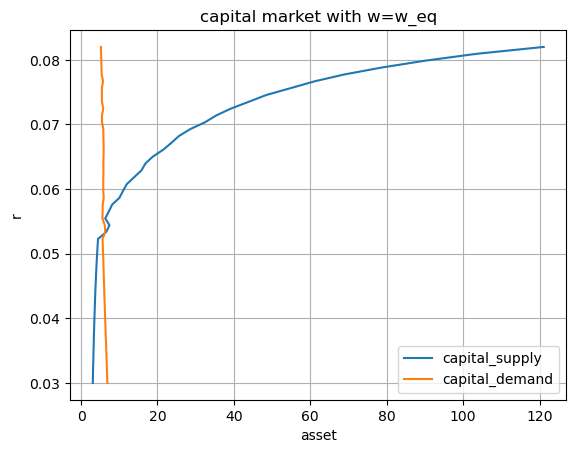

In [225]:
# Plot
plt.plot(k_supply,rgrid,label="capital_supply")
plt.plot(k_demand,rgrid,label="capital_demand")
plt.title('capital market with w=w_eq')
plt.ylabel('r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

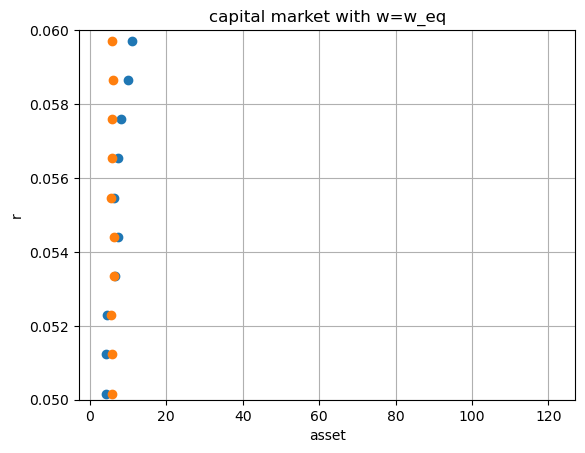

In [230]:
# Plot
plt.scatter(k_supply,rgrid,label="capital_supply")
plt.scatter(k_demand,rgrid,label="capital_demand")
plt.title('capital market with w=w_eq')
plt.ylabel('r')
plt.xlabel('asset')
# plt.legend()
plt.ylim(0.05,0.06)
plt.grid(True)

In [227]:
rgrid

array([0.03      , 0.03106122, 0.03212245, 0.03318367, 0.0342449 ,
       0.03530612, 0.03636735, 0.03742857, 0.0384898 , 0.03955102,
       0.04061224, 0.04167347, 0.04273469, 0.04379592, 0.04485714,
       0.04591837, 0.04697959, 0.04804082, 0.04910204, 0.05016327,
       0.05122449, 0.05228571, 0.05334694, 0.05440816, 0.05546939,
       0.05653061, 0.05759184, 0.05865306, 0.05971429, 0.06077551,
       0.06183673, 0.06289796, 0.06395918, 0.06502041, 0.06608163,
       0.06714286, 0.06820408, 0.06926531, 0.07032653, 0.07138776,
       0.07244898, 0.0735102 , 0.07457143, 0.07563265, 0.07669388,
       0.0777551 , 0.07881633, 0.07987755, 0.08093878, 0.082     ])

In [228]:
k_supply-k_demand

array([ -3.81210036,  -3.71937804,  -3.61954309,  -3.50748528,
        -3.40546034,  -3.30335494,  -3.19268607,  -3.09028857,
        -2.96787208,  -2.85179601,  -2.73724908,  -2.61906239,
        -2.50786382,  -2.37551035,  -2.25202126,  -2.10839366,
        -1.97944359,  -1.84100888,  -1.70278275,  -1.52219879,
        -1.35406473,  -1.20083785,   0.26574949,   1.21847181,
         0.7271242 ,   1.61524139,   2.46344212,   4.1201103 ,
         5.16283228,   6.18202044,   8.06223213,   9.95082196,
        11.0048301 ,  12.90000168,  15.56873913,  17.72925266,
        19.75114744,  22.70261738,  26.9115399 ,  29.88229535,
        33.38881109,  38.42505527,  43.10493634,  49.48487006,
        55.47776019,  63.66348893,  73.42023325,  84.86813624,
        98.35430458, 115.91679229])

## solve equilibrium price $(w,r)$  main body

In [237]:
# nested bisection
def r_iteration(tol_r,tol_eq):
    rmin=0.05228571
    rmax=0.05546939
    r0=1/2*(rmin+rmax)
    error = np.inf
    count = 0
    max_iter = 1000
    print_skip = 50
    while count < max_iter and error > tol_r:
        w = w_update(r0,tol_eq)
        res_k = equilibrium_k(w,r0,tol_eq)
        if res_k < 0:
            rmin=r0
        else:
            rmax=r0
        r0 = 1/2*(rmin+rmax)
        error = np.abs(rmax-rmin)
        count = count + 1
        print('rmin=',rmin,'rmax=',rmax,'r=',r0,'iteration times=',count)
    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {count} iterations.")
    return r0 

In [238]:
start_time = timeit.default_timer()
r_eq = r_iteration(1e-5,1e-5)
print("The time difference is :", timeit.default_timer() - start_time)

w= 1.0 r= 0.053877549999999996 labor suply= 0.9445665529931679 labor demand= 2.7914004367383853 res_l= -1.8468338837452174
w= 1.25 r= 0.053877549999999996 labor suply= 0.9904862609072017 labor demand= 0.6919731803842065 res_l= 0.2985130805229952
w= 1.125 r= 0.053877549999999996 labor suply= 0.9676675157976904 labor demand= 1.5707375303846143 res_l= -0.6030700145869239
w= 1.1875 r= 0.053877549999999996 labor suply= 0.985017014222468 labor demand= 0.9942360787367188 res_l= -0.009219064514250808
w= 1.21875 r= 0.053877549999999996 labor suply= 0.9870119723265132 labor demand= 0.8643360765496482 res_l= 0.122675895776865
w= 1.203125 r= 0.053877549999999996 labor suply= 0.9850896411797158 labor demand= 0.9493524473503117 res_l= 0.0357371938294041
w= 1.1953125 r= 0.053877549999999996 labor suply= 0.9850616108991623 labor demand= 0.9713816692377997 res_l= 0.01367994166136266
w= 1.19140625 r= 0.053877549999999996 labor suply= 0.9850319224095616 labor demand= 0.9829683144159382 res_l= 0.002063607

In [239]:
w_eq = w_update(r_eq,1e-5)

w= 1.0 r= 0.0542102196875 labor suply= 0.9445658283739342 labor demand= 2.7832591619455056 res_l= -1.8386933335715714
w= 1.25 r= 0.0542102196875 labor suply= 0.9904742411091764 labor demand= 0.6901753156960231 res_l= 0.3002989254131533
w= 1.125 r= 0.0542102196875 labor suply= 0.967684116391244 labor demand= 1.5665490788568461 res_l= -0.5988649624656022
w= 1.1875 r= 0.0542102196875 labor suply= 0.980075979397499 labor demand= 1.1093696369326462 res_l= -0.1292936575351472
w= 1.21875 r= 0.0542102196875 labor suply= 0.9870020403700066 labor demand= 0.8613338883992845 res_l= 0.12566815197072212
w= 1.203125 r= 0.0542102196875 labor suply= 0.9850917342364471 labor demand= 0.9458113683927991 res_l= 0.039280365843648024
w= 1.1953125 r= 0.0542102196875 labor suply= 0.9801280962405549 labor demand= 1.0834976761769208 res_l= -0.10336957993636597
w= 1.19921875 r= 0.0542102196875 labor suply= 0.9801242460881304 labor demand= 1.0723086796542884 res_l= -0.09218443356615802
w= 1.201171875 r= 0.05421021

In [240]:
equilibrium_l(w_eq,r_eq,1e-5)

w= 1.2001914978027344 r= 0.0542102196875 labor suply= 0.9803610043496709 labor demand= 1.0649923109827002 res_l= -0.08463130663302931


-0.08463130663302931

In [241]:
equilibrium_k(w_eq,r_eq,1e-5)

w= 1.2001914978027344 r= 0.0542102196875 capital supply= 6.533385159801248 capital demand= 6.1637618367606155 res_k= 0.3696233230406323


0.3696233230406323

In [242]:
from tqdm import tqdm

def labor_curve(n_a, wmin, wmax, wgrid_number,r):
    wgrid = np.linspace(wmin, wmax, wgrid_number)
    l_supply = np.zeros(wgrid_number)
    l_demand = np.zeros(wgrid_number)
    for i in tqdm(range(wgrid_number)):
        w0 = wgrid[i]
        capital_supply,capital_demand,l_supply[i],l_demand[i]=capital_and_labor(w0,r,1e-4) #capital 只是为了占位
    return wgrid, l_supply, l_demand

wgrid, l_supply, l_demand = labor_curve(
    n_a=n_k, wmin=0.5, wmax=1.5, wgrid_number=50,r=r_eq
)


100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


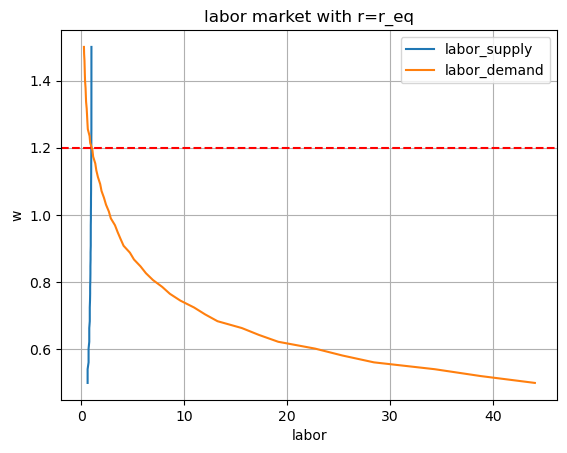

In [253]:
# Plot
plt.plot(l_supply,wgrid,label="labor_supply")
plt.plot(l_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.axhline(w_eq,ls='--',color='r')
plt.legend()
plt.grid(True)

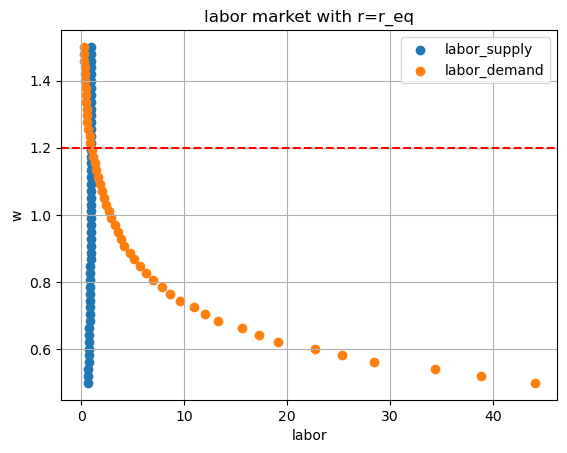

In [254]:
plt.scatter(l_supply,wgrid,label="labor_supply")
plt.scatter(l_demand,wgrid,label="labor_demand")
plt.title('labor market with r=r_eq')
plt.ylabel('w')
plt.xlabel('labor')
plt.axhline(w_eq,ls='--',color='r')
# plt.xlim([0,5])
plt.legend()
plt.grid(True)

In [257]:
# from tqdm import tqdm

def capital_curve(n_a, rmin, rmax, rgrid_number,w):
    rgrid = np.linspace(rmin, rmax, rgrid_number)
    a_supply = np.zeros(rgrid_number)
    a_demand = np.zeros(rgrid_number)
    for i in tqdm(range(rgrid_number)):
        r0 = rgrid[i]
        a_supply[i],a_demand[i],l_supply,l_demand=capital_and_labor(w,r0,1e-4) #labor 只是为了占位
    return rgrid, a_supply, a_demand

rgrid, k_supply, k_demand = capital_curve(
    n_a=n_k, rmin=0.03, rmax=0.082, rgrid_number=50,w=w_eq
)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:31<00:00,  1.84s/it]


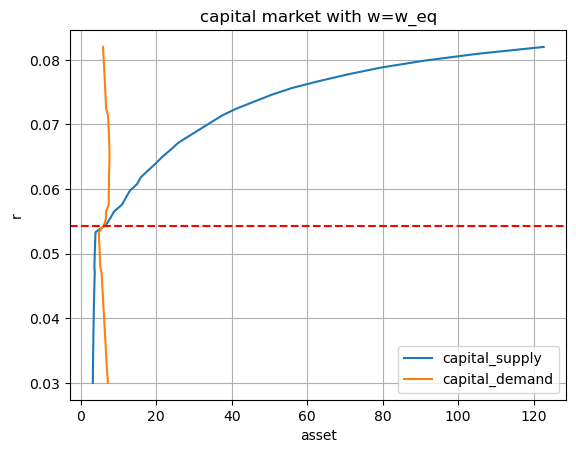

In [258]:
# Plot
plt.plot(k_supply,rgrid,label="capital_supply")
plt.plot(k_demand,rgrid,label="capital_demand")
plt.title('capital market with w=w_eq')
plt.ylabel('r')
plt.axhline(r_eq,ls='--',color='r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

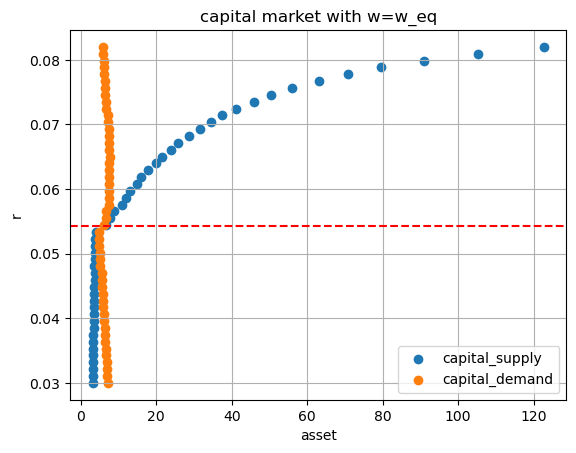

In [259]:
plt.scatter(k_supply,rgrid,label="capital_supply")
plt.scatter(k_demand,rgrid,label="capital_demand")
plt.title('capital market with w=w_eq')
plt.ylabel('r')
plt.axhline(r_eq,ls='--',color='r')
plt.xlabel('asset')
plt.legend()
plt.grid(True)

In [248]:
# Compute Demand and Supply in Capital Market
def capital_and_labor_and_goods(w,r,tol):
    bound_matrix = capital_bound_matrix(w,r)
    V0 = np.zeros((n_k, n_z))
    V_new,g,state_entrepreneur=V_iteration(V0,1e-7,w,r,bound_matrix)
    Q=transQ_sparse(g)
    psi0 = np.ones((n_k * n_z))/(n_k * n_z)
    ss=sparse_stationary_distribution_iteration(Q,psi0,tol)
    tmp = ss.reshape((n_k, n_z)) # joint stable distribution
    # capital_supply=np.dot(kgrid,a_dist)
    state_worker=np.ones((n_k, n_z))-state_entrepreneur
    R=r+delta
    ## compute demand and supply
    capital_demand_joint= np.zeros((n_k, n_z))    
    capital_supply_joint= np.zeros((n_k, n_z))
    labor_demand_joint= np.zeros((n_k, n_z))
    labor_supply_joint=np.zeros((n_k, n_z)) 
    depreciation_joint = np.zeros((n_k,n_z))    
    goods_supply_joint = np.zeros((n_k, n_z))   
    goods_demand_joint = np.zeros((n_k, n_z))        
    for i_k in range(n_k):
        for i_z in range(n_z):
            k = capital_demand(i_k,i_z,w,r,bound_matrix)*state_entrepreneur[i_k,i_z]
            capital_demand_joint[i_k,i_z]=tmp[i_k,i_z]*k
            l = (theta*zgrid[i_z]*(k**alpha)/w)**(1/(1-theta))
            labor_demand_joint[i_k,i_z]=tmp[i_k,i_z]*l          
            capital_supply_joint[i_k,i_z]=tmp[i_k,i_z]*g[i_k,i_z]
            labor_supply_joint[i_k,i_z]=state_worker[i_k,i_z]*tmp[i_k,i_z]
            goods_demand_joint[i_k,i_z]=budget_worker(kgrid[i_k], g[i_k,i_z], w, r)*tmp[i_k,i_z]
            goods_supply_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*(zgrid[i_z]*(k**alpha)*(l**theta))*tmp[i_k,i_z]
            depreciation_joint[i_k,i_z]=state_entrepreneur[i_k,i_z]*tmp[i_k,i_z]*fc_m
    capital_supply=np.sum(capital_supply_joint)
    labor_supply=np.sum(labor_supply_joint)
    k_demand=np.sum(capital_demand_joint)
    labor_demand=np.sum(labor_demand_joint)
    depreciation = np.sum(depreciation_joint)
    goods_demand = np.sum(goods_demand_joint)
    goods_supply = np.sum(goods_supply_joint)

    
    return goods_demand,goods_supply,capital_supply,k_demand,labor_supply,labor_demand,depreciation

In [249]:
goods_demand,goods_supply,capital_supply,k_demand,labor_supply,labor_demand,depreciation=capital_and_labor_and_goods(w_eq,r_eq,1e-4)

In [250]:
print('goods_demand=',goods_demand,'goods_supply=',goods_supply,'capital_supply=',capital_supply,'capital_demand=',k_demand,'labor_supply=',labor_supply,'labor_demand=',labor_demand,'fixed cost=',depreciation)


goods_demand= 1.5643896244668494 goods_supply= 2.6195000097174486 capital_supply= 6.613677358910731 capital_demand= 6.192661207367035 labor_supply= 0.9801264837152996 labor_demand= 1.0694585048397978 fixed cost= 0.09300805621243344


In [251]:
goods_supply-goods_demand-delta*capital_supply-(1+r_eq)*depreciation

0.5602397003435385

In [252]:
goods_supply-goods_demand-delta*k_demand-(1+r_eq)*depreciation

0.5855006694361603